In [1]:
import os
os.chdir(os.getenv("WORKINGDIR"))
from tqdm.notebook import tqdm
import concurrent.futures
import numpy as np
from numpy.typing import ArrayLike
from scipy.optimize import curve_fit
from scipy.stats import chi2
import scipy.constants as cte
import pandas as pd
import pickle
from astropy.io import fits
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from skipper_image_analysis.utils import (
    correct_overscan, get_rowcol_ovserscan, prepare_frame, filtro_dipolos,
    frame_coords_to_ccd_coords, ccd_coords_to_frame_coords, gaussiana
)

def intensidad_func(tph, tau, PcD):
    npump = 3000
    n = 8
    return npump*PcD*(np.exp(-tph/tau) - np.exp(-n*tph/tau))


def tau_func(T, e_kb, tau_0):
    return tau_0 / (T**2) * np.exp(e_kb/T)


# def d_tau_func_dT(T, e_kb, tau_0):
#     return -tau_0* (2 * T + e_kb) * np.exp(e_kb / T) / T**4


def seccion_eficaz(tau_0):
    h_planck = cte.h / cte.eV  # eV·s
    m_e = cte.electron_mass / cte.eV * cte.c**2  # eV/c²
    k_boltz = cte.Boltzmann / cte.eV  # eV/K
    m_cond = 0.41 * m_e  # eV/c²
    m_dens = 0.94 * m_e  # eV/c²
    sigma = (
        ((h_planck**3) * m_cond**0.5)  # eV³·s³·sq(eV)/c
        / (2 * tau_0 * (3**0.5) * (k_boltz**2) * (2 * np.pi * m_dens)**(3/2))  # s·T²·eV²·sq(eV³)/c³K²
    )  # s²c²
    return sigma * (cte.c**2) * (100**2)  # cm²


# Matplotlib settings
%config InlineBackend.figure_format = "retina"  # For high dpi figures in notebook
plt.rcParams["font.family"] = "serif"
plt.rcParams["mathtext.fontset"] = "cm"
plt.rcParams["figure.dpi"] = 120
plt.rcParams["legend.fontsize"] = "medium"
plt.rcParams["axes.labelsize"] = "large"


GANANCIA = {
    0: 210,
    1: 232,
    2: 207,
    3: 159
}
PRESCAN_PIX = 8

CARPETAS_POR_TEMP: dict[str, list[str]] = {
    126: [
        "skipper_data/TRAPS/02JUN2024_126K_EXP30s_LED_30s",
    ],
    127: [
        "skipper_data/TRAPS/06MAY2024_127K_LED_30s",
    ],
    130: [
        "skipper_data/TRAPS/01JUN2024_130K_EXP30s_LED_30s",
    ],
    135: [
        "skipper_data/TRAPS/02JUN2024_135K_EXP30s_LED_30s",
    ],
    140: [
        "skipper_data/TRAPS/01JUN2024_140K_EXP30s_LED_30s",
    ],
    145: [
        "skipper_data/TRAPS/02JUN2024_145K_EXP30s_LED_30s",
    ],
    151: [
        "skipper_data/TRAPS/31MAY2024_151K_EXP30s_LED_30s",
    ],
    152: [
        "skipper_data/TRAPS/03JUN2024_152p5K_EXP30s_LED_30s",
    ],
    160: [
        "skipper_data/TRAPS/03JUN2024_160K_EXP30s_LED_30s",
    ],
    166: [
        "skipper_data/TRAPS/03JUN2024_166K_EXP30s_LED_30s",
    ],
    171: [
        "skipper_data/TRAPS/04JUN2024_171K_EXP30s_LED_30s",
    ],
    172: [
        "skipper_data/TRAPS/04JUN2024_172K_EXP30s_LED_30s",
    ],
    180: [
        "skipper_data/TRAPS/19AUG2024_180K_EXP30s_LED_30s",
    ],
    190: [
        "skipper_data/TRAPS/19AUG2024_190K_EXP30s_LED_30s",
    ],
    195: [
        "skipper_data/TRAPS/19AUG2024_195K_EXP30s_LED_30s",
    ]
}
DATA_DIR_COUNT = sum([len(dir_list) for dir_list in CARPETAS_POR_TEMP.values()])
RESULTS_DIR = "skipper_image_analysis/TRAPS_estudio_fondo"
CLOCKS_TO_SEC = 15e6  # Hz
DTPH_VALS = np.array(
    [50, 75, 100, 150, 200, 300, 400, 600, 800, 1200, 1600, 2400, 3200, 4800, 6400, 9600, 12800, 19200, 25600, 38400, 51200, 76800, 102400, 153600, 204800]
)
# Define Bins so that each value is at the center of the bin in a log scale
DTPH_BINS = np.sqrt(DTPH_VALS[1:] * DTPH_VALS[:-1])
DTPH_BINS = np.insert(DTPH_BINS, 0, DTPH_VALS[0]*0.8)
DTPH_BINS = np.append(DTPH_BINS, DTPH_VALS[-1]*1.2)

bounds = np.arange(125-2.5, 195+2.5, 5)  # K
norm = mcolors.BoundaryNorm(bounds, plt.cm.plasma.N, extend="max")
temp_colors = plt.cm.ScalarMappable(
    norm=norm,
    cmap="plasma",
)
dtph_colors = plt.cm.ScalarMappable(
    norm=mcolors.LogNorm(DTPH_VALS[0]/CLOCKS_TO_SEC, DTPH_VALS[-1]/CLOCKS_TO_SEC),
    cmap="viridis"
)

In [2]:
# Validando Ancho del Overscan
temperatura = 190
data_dir = CARPETAS_POR_TEMP[temperatura][0]
files_in_dir = [
    file for file in os.listdir(data_dir)
    if (file.endswith(".fits") and ("dTph" in file))
]
files_in_dir.sort(key=lambda x: int(x.rsplit("_")[5][4:]))
file = files_in_dir[0]
skipper_image = fits.open(f'{data_dir}/{file}')
r_overscan, c_overscan = get_rowcol_ovserscan(skipper_image)
# Extract Read Error from Column Overscan
frame_idx = 0
overscan_frame = (
    skipper_image[frame_idx].data[:, -c_overscan:]
    / GANANCIA[frame_idx]
)  # e⁻

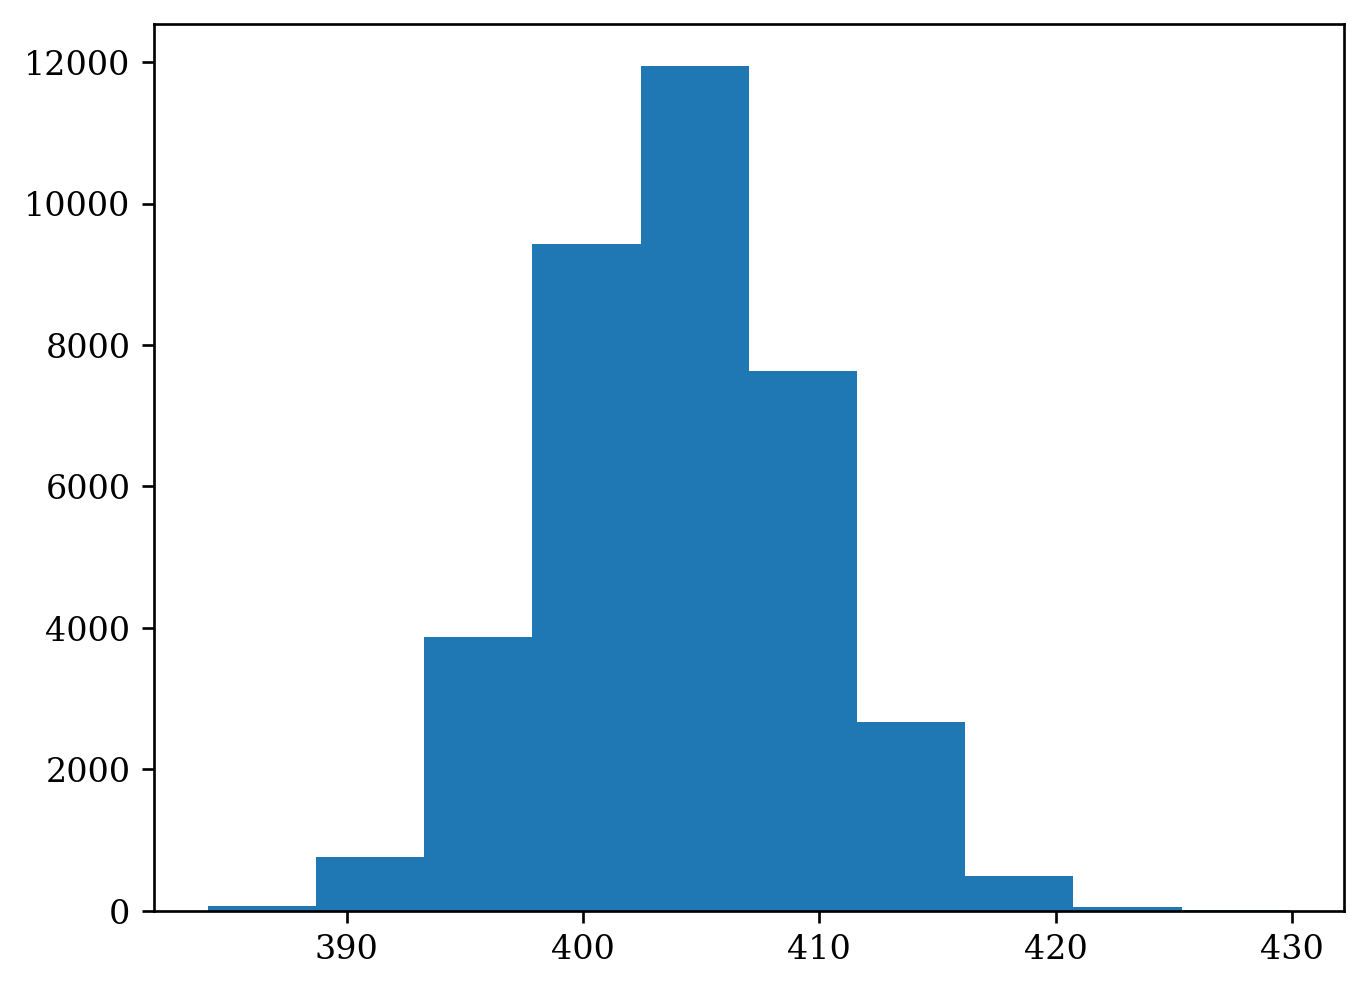

In [3]:
plt.hist(overscan_frame.flatten())
plt.show()

In [4]:
# Validando Ancho del Overscan
temperatura = 195
data_dir = CARPETAS_POR_TEMP[temperatura][0]
files_in_dir = [
    file for file in os.listdir(data_dir)
    if (file.endswith(".fits") and ("dTph" in file))
]
files_in_dir.sort(key=lambda x: int(x.rsplit("_")[5][4:]))
file = files_in_dir[0]
skipper_image = fits.open(f'{data_dir}/{file}')
r_overscan, c_overscan = get_rowcol_ovserscan(skipper_image)
# Extract Read Error from Column Overscan
frame_idx = 0
overscan_frame = (
    skipper_image[frame_idx].data[:, -c_overscan:]
    / GANANCIA[frame_idx]
)  # e⁻
# Fit Gaussian to Column Overscan Distribution
charge_frec, charge_bins = np.histogram(
    overscan_frame.flatten(),
    bins=np.linspace(
        overscan_frame.min(),
        # np.min([overscan_frame.max(), -overscan_frame.min()]),
        overscan_frame.max(),
        500
    ),
    density=True,
)
try:  # Try to fit a Gaussian to the distribution
    popt, *_ = curve_fit(
        gaussiana,
        charge_bins[:-1],
        charge_frec,
        p0=[1 / np.sqrt(2 * np.pi * 4), 0, overscan_frame.std()],
    )
    error = np.abs(popt[2])  # e⁻
except RuntimeError:  # If the fit fails, use the standard deviation and plot
    error = overscan_frame.std()  # e⁻
    # plt.plot(charge_bins[:-1], charge_frec, ".")
    # plt.plot(charge_bins[:-1], gaussiana(charge_bins[:-1], *popt))
    # plt.show()

/tmp/ipykernel_290142/2657128960.py:30: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, *_ = curve_fit(


In [5]:
error

5.708233833312988

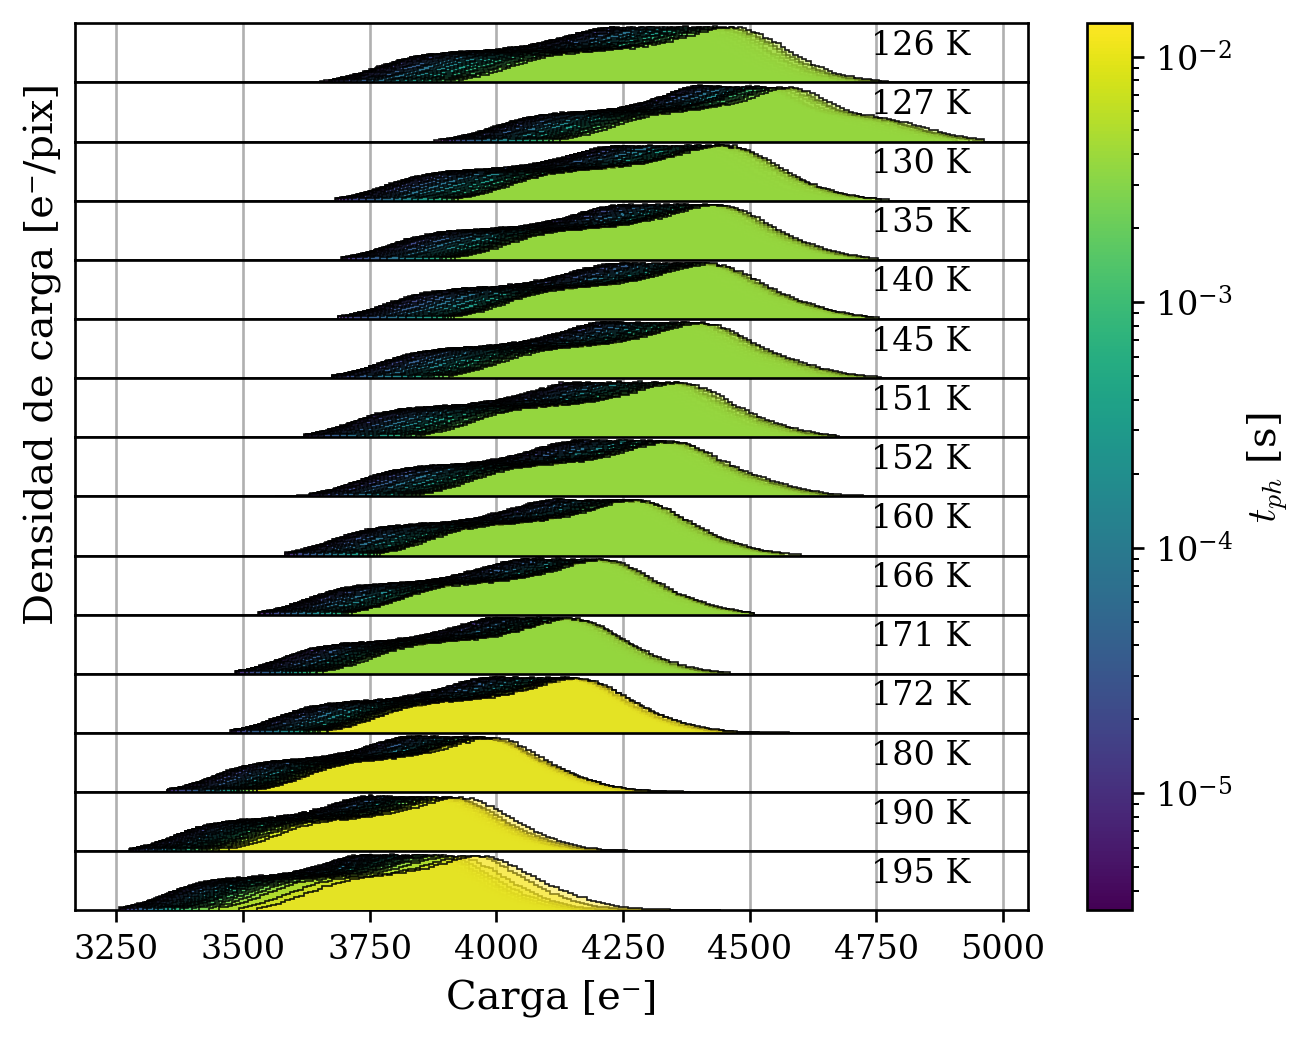

In [6]:
# Graficamos la distribución de carga para cada barrido
plt.close("all")
%matplotlib inline    
dists_por_dir = {}

fig, axs = plt.subplots(len(CARPETAS_POR_TEMP), 1, sharex=True, squeeze=False)
axs = axs[:, 0]
fig.subplots_adjust(hspace=0)
ax_idx = 0
for temperatura, carpetas in CARPETAS_POR_TEMP.items():
    for data_dir in carpetas:
        files_in_dir = [
            file for file in os.listdir(data_dir)
            if (file.endswith(".fits") and ("dTph" in file))
        ]
        files_in_dir.sort(key=lambda x: int(x.rsplit("_")[5][4:]))
        tph_vals = []
        medianas = []
        standard_devs =  []
        ax = axs[ax_idx]
        for file in files_in_dir:
            test_image = fits.open(f'{data_dir}/{file}')
            # print(data_dir, file, sep="")
            dtph = int(file.rsplit("_")[5][4:])
            row_overscan_len, col_overscan_len = get_rowcol_ovserscan(test_image)
            test_image = correct_overscan(test_image)
            carga_area_activa = []
            for frame_idx in [0, 1]:
                # area_activa, _, _ = prepare_frame(test_image, frame_idx)
                test_frame = test_image[frame_idx].data/GANANCIA[frame_idx]
                area_activa = test_frame[1:-row_overscan_len, PRESCAN_PIX:-col_overscan_len]
                # area_activa = test_frame[-row_overscan_len:, PRESCAN_PIX:-col_overscan_len]
                # area_activa = test_frame.copy()
                carga_area_activa.append(area_activa.flatten())
            carga_area_activa = np.concatenate(carga_area_activa)
            medianas.append(np.median(carga_area_activa))
            carga_area_activa = carga_area_activa[
                (carga_area_activa > np.quantile(carga_area_activa, 0.005))
                & (carga_area_activa < np.quantile(carga_area_activa, 0.99))
            ]
            standard_devs.append(
                np.std(
                    carga_area_activa,
                    ddof=1
                )
            )
            tph_vals.append(dtph/CLOCKS_TO_SEC)
            ax.hist(
                carga_area_activa,
                bins=100,
                color=dtph_colors.to_rgba(dtph/CLOCKS_TO_SEC),
                alpha=0.5, density=True, zorder=10
            )
            ax.hist(
                carga_area_activa,
                bins=100,
                color="k", histtype="step", lw=0.5,
                alpha=0.9, density=True, zorder=10
            )
        dists_por_dir[data_dir] = (medianas, standard_devs, tph_vals)
    # ax.set_xticks([])
    # ax.set_xlim(1000, 4500)
    ax.text(0.94, 0.9, f"{temperatura} K",
            # c=temp_colors.to_rgba(temperatura),
            transform=ax.transAxes, ha="right", va="top")
    ax.grid(True)
    ax.set_yticks([])
    # ax.set_ylabel(f"{temperatura} K")
    if ax_idx == 1:
        ax.set_ylabel("Densidad de carga [e⁻/pix]", loc="top")
    ax_idx += 1
# ax.set_xticks(range(1000, 5000, 500))
# ax.set_xlim(1000, 4500)
ax.set_xlabel("Carga [e⁻]")
fig.colorbar(dtph_colors, label="$t_{ph}$ [s]", ax=axs)
plt.show()

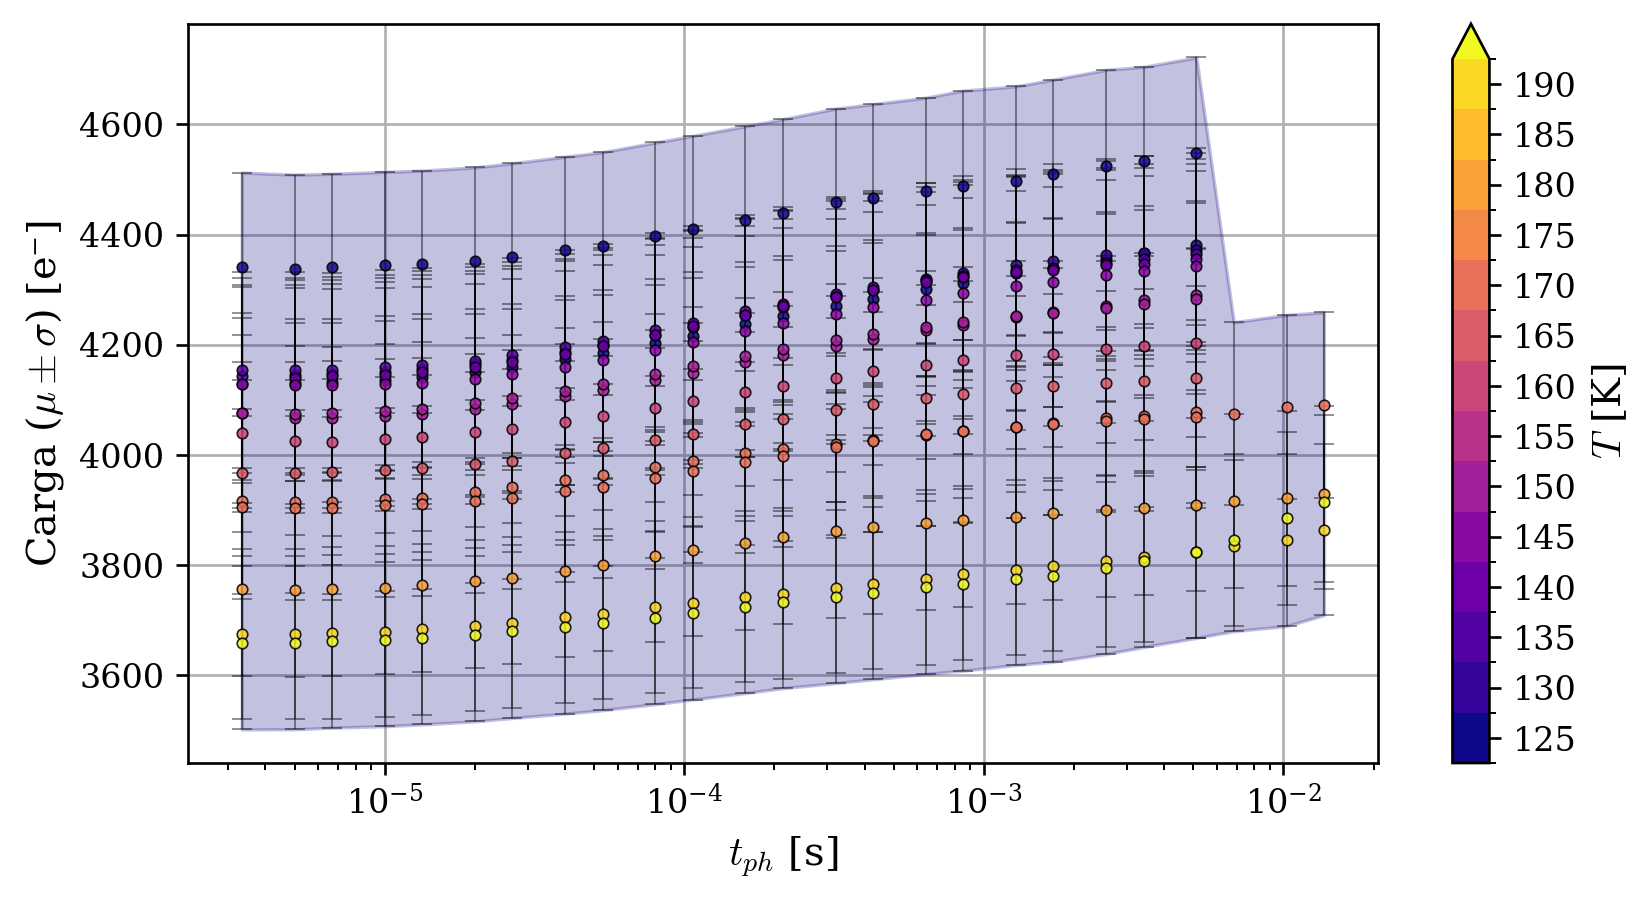

In [7]:
# Graficamos la carga media en función del t_ph
plt.figure(figsize=(8, 4))
median_vals = np.full(
    (DATA_DIR_COUNT, len(DTPH_VALS)), np.nan
)
std_vals = np.full(
    (DATA_DIR_COUNT, len(DTPH_VALS)), np.nan
)
for temperatura, carpetas in CARPETAS_POR_TEMP.items():
    for data_dir in carpetas:
        medianas, standard_devs, tph_vals = dists_por_dir[data_dir]
        plt.scatter(tph_vals, medianas, color=temp_colors.to_rgba(temperatura), zorder=10,
                    linewidth=0.5, edgecolor="k", alpha=0.85, s=10)
        plt.errorbar(tph_vals, medianas, yerr=standard_devs, ls="none", zorder=5,
                        color="k", mec="k", mew=0.5, lw=0.5, capsize=3, alpha=0.5)
        
        dir_idx = list(CARPETAS_POR_TEMP.keys()).index(temperatura)
        for tph_idx, t_ph in enumerate(DTPH_VALS/CLOCKS_TO_SEC):
            if t_ph in tph_vals:
                tph_data_idx = tph_vals.index(t_ph)
                median_vals[dir_idx, tph_idx] = medianas[tph_data_idx]
                std_vals[dir_idx, tph_idx] = standard_devs[tph_data_idx]
plt.fill_between(
    DTPH_VALS/CLOCKS_TO_SEC,
    np.nanmin(median_vals - std_vals, axis=0),
    np.nanmax(median_vals + std_vals, axis=0),
    color=temp_colors.to_rgba(0), alpha=0.25, zorder=4
)
plt.grid()
plt.xscale("log")
plt.xlabel("$t_{ph}$ [s]")
plt.ylabel("Carga ($\mu \pm \sigma$) [e⁻]")
plt.colorbar(temp_colors, label="$T$ [K]", ax=plt.gca(), ticks=temp_colors.norm.boundaries+2.5)
plt.show()

In [8]:
def carga_archivos(
    temperatura: int, dir_idx: int, frame_idx: int,
    threshold_factor: float = 4, corte_simetria: float = 30
) -> tuple[dict, dict, dict, dict, fits.hdu.hdulist.HDUList, dict]:
    """Carga los archivos de una carpeta de una temperatura y un número de archivo \
específicos. Luego, aplica el filtro de dipolos a cada frame y devuelve las \
coordenadas de los dipolos, los valores de los dipolos, una máscara con los dipolos \
encontrados, el objeto fits con los datos de la CCD en la última imagen procesada y \
un diccionario con los errores de cada frame.

    Parameters:
    -----------

        `temperatura {int}`: Temperatura de la CCD en Kelvin durante la toma de datos.

        `dir_idx {int}`: Índice de la carpeta con los archivos a cargar cuando existe \
más de una carpeta por temperatura.

        `frame_idx {int}`: Índice del frame/cuadrante de la CCD a analizar.

        `threshold_factor {float, optional}`: Factor por el que se multiplica al \
ancho de la distribución de carga en la CCD para calcular el umbral de selección. Es \
decir, un dipolo se considera válido si su autocorrelación es menor que \
`-(threshold_factor * ancho_dist)**2`, donde `ancho_dist` es el ancho de la distribución \
de carga en la CCD. Valor por defecto = 3.

        `corte_simetria {float, optional}`: Porcentaje de la diferencia en simetría \
para el filtro en la detección de dipolos. Valor por defecto = 20.

    Returns:
    --------

        `{tuple[dict, dict, dict, dict, fits.hdu.hdulist.HDUList, dict]}`: Diccionarios\
 con las coordenadas de los dipolos, los valores de los dipolos, una máscara con los \
dipolos encontrados, el objeto fits con los datos de la CCD en la última imagen y un \
diccionario con los errores de cada frame.
    """
    global CARPETAS_POR_TEMP
    # Cargar Archivos desde sus Carpetas por Temperatura
    data_dir = CARPETAS_POR_TEMP[temperatura][dir_idx]
    files_in_dir = os.listdir(data_dir)
    valid_formats = ["fits",]
    files_in_dir = [f for f in files_in_dir
                    if (f.rsplit(".")[-1] in valid_formats) and ("dTph" in f)]
    files_in_dir.sort(key=lambda x: int(x.rsplit("_")[5][4:]))
    frames_dict = dict()
    mediana_dict = dict()
    error_dict = dict()
    coords_dict = dict()
    vals_dict = dict()
    mascara_dipolos = dict()
    for file in tqdm(files_in_dir, desc="Procesando Archivos", leave=True):
        dtph = int(file.rsplit("_")[5][4:])
        if dtph in coords_dict:
            continue
        test_image = fits.open(f'{data_dir}/{file}')
        frames_dict[dtph], mediana_dict[dtph], error_dict[dtph] = prepare_frame(
            test_image, frame_idx, remove_row_median=True,
        )  # e⁻
        coords_dict[dtph], vals_dict[dtph], mascara_dipolos[dtph] = filtro_dipolos(
            frames_dict[dtph], threshold_factor, corte_simetria
        )
    return coords_dict, frames_dict, vals_dict, mediana_dict, error_dict, mascara_dipolos

In [9]:
def identificacion_e_intensidad(
    coords_dict: dict,
    frames_dict: dict,
    vals_dict: dict,
    mediana_dict: dict,
    errors_dict: dict,
) -> tuple[list, list, list, list]:
    """Identifica trampas en todos los dtph y busca la intensidad de cada trampa en \
todos los dtph.
    """
    trampas_halladas = []
    intensidad_por_trampa = []
    error_por_trampa = []
    dtph_vals = list(coords_dict.keys())
    dtph_vals = [dtph_vals[i] for i in np.argsort(dtph_vals)]
    error_vals = [  # e⁻
        errors_dict[dtph]/np.sqrt(2) for dtph in dtph_vals
    ]  # Error propagado al calcular la intensidad como la mitad de la diferencia
    for dtph in tqdm(
        dtph_vals[::-1],
        desc="Recorriendo dTph",
        total=len(dtph_vals),
        leave=False,
    ):
        coordenadas_trampas = coords_dict[dtph]
        valores_trampas = vals_dict[dtph]
        mediana_trampas = mediana_dict[dtph]
        for coords, valor in zip(
            coordenadas_trampas, valores_trampas
        ):
            if coords in trampas_halladas:
                # Si ya se encontró la trampa, no hace falta volver a propagar.
                propagar_a_todos = False
            # elif valor > (mediana_trampas / 3):
            #     # Si la intensidad del dipolo es mayor a un tercio de la carga media
            #     # de la CCD, entonces seguro es una trampa y hay que propagarla.
            #     propagar_a_todos = True
            elif sum([coords in coords_dict[t_ph] for t_ph in dtph_vals]) >= 3:
                # !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
                # Si la trampa está en más de dos dtph, entonces seguro es una trampa
                # y hay que propagarla.
                propagar_a_todos = True
            else:
                # Si no se cumple ninguna de las condiciones anteriores, no se
                # propaga la trampa.
                propagar_a_todos = False
            if propagar_a_todos:
                # Propagar la trampa a todos los dtph y guardamos las curvas de I(t_ph).
                intensidades_trampa = []
                for dtph_frames in dtph_vals:
                    frame = frames_dict[dtph_frames]
                    intensidad_trampa = np.abs(  # e⁻
                        frame[coords[0]] - frame[coords[1]]
                    ) / 2
                    intensidades_trampa.append(intensidad_trampa)
                error_por_trampa.append(error_vals)
                intensidad_por_trampa.append(intensidades_trampa)
                trampas_halladas.append(coords)
    return trampas_halladas, intensidad_por_trampa, error_por_trampa, dtph_vals

## Análisis de la Intensidad de las Trampas

In [10]:
def process_temperature(temperatura, carpetas):
    trampas = []  # trampas[dir_idx][coord_idx]
    intensidad = []  # intensidad[dir_idx][coord_idx][dtph_idx]
    dtph = []  # dtph[dir_idx][dtph_idx]
    error = []  # error[dir_idx][coord_idx][dtph_idx]
    for dir_idx in range(len(carpetas)):
        print(f"Procesando Carpeta {carpetas[dir_idx]}...")
        for frame_idx in [0, 1]:
            print(f"Recorriendo Frame {frame_idx}...")
            coords_dict, frames_dict, vals_dict, mediana_dict, errors_dict, _ = carga_archivos(
                temperatura, dir_idx, frame_idx, threshold_factor=3, corte_simetria=30,
            )
            trampas_halladas, intensidad_por_trampa, error_por_trampa, dtph_vals = identificacion_e_intensidad(
                coords_dict, frames_dict, vals_dict, mediana_dict, errors_dict
            )
            # Transformamos las coordenadas de los dipolos al sistema de coords de la CCD
            CCDNROW = int(test_image[frame_idx].header["CCDNROW"])
            CCDNCOL = int(test_image[frame_idx].header["CCDNCOL"])
            trampas_halladas = [
                (
                    frame_coords_to_ccd_coords(coords[0], frame_idx, CCDNROW, CCDNCOL),
                    frame_coords_to_ccd_coords(coords[1], frame_idx, CCDNROW, CCDNCOL),
                ) for coords in trampas_halladas
            ]
            trampas.append(trampas_halladas)
            intensidad.append(intensidad_por_trampa)
            error.append(error_por_trampa)
            dtph.append(dtph_vals)
    return trampas, intensidad, error, dtph, temperatura

try:
    trampas_temp = pickle.load(open(f"{RESULTS_DIR}/trampas.pkl", "rb"))
    intensidades_temp = pickle.load(open(f"{RESULTS_DIR}/intensidades.pkl", "rb"))
    errores_temp = pickle.load(open(f"{RESULTS_DIR}/errores.pkl", "rb"))
    dtph_temp = pickle.load(open(f"{RESULTS_DIR}/dtph.pkl", "rb"))
    print(f"Resultados intermedios cargados desde Pickles en {RESULTS_DIR}")
except FileNotFoundError:
    trampas_temp: dict[int, list[list[tuple[tuple[int]]]]] = dict()
    intensidades_temp: dict[int, list[list[list[float]]]] = dict()
    errores_temp: dict[int, list[list[list[float]]]] = dict()
    dtph_temp: dict[int, list[list[int]]] = dict()
    with concurrent.futures.ThreadPoolExecutor() as executor:
        futures = []
        for temperatura, carpetas in CARPETAS_POR_TEMP.items():
            futures.append(executor.submit(process_temperature, temperatura, carpetas))
        
        for future in concurrent.futures.as_completed(futures):
            trampas, intensidad, error, dtph, temperatura = future.result()
            trampas_temp[temperatura] = trampas
            intensidades_temp[temperatura] = intensidad
            errores_temp[temperatura] = error
            dtph_temp[temperatura] = dtph
    # Save to Pickle
    if not os.path.exists(RESULTS_DIR):
        os.mkdir(RESULTS_DIR)
    with open(f"{RESULTS_DIR}/trampas.pkl", "wb") as file:
        pickle.dump(trampas_temp, file)
    with open(f"{RESULTS_DIR}/intensidades.pkl", "wb") as file:
        pickle.dump(intensidades_temp, file)
    with open(f"{RESULTS_DIR}/errores.pkl", "wb") as file:
        pickle.dump(errores_temp, file)
    with open(f"{RESULTS_DIR}/dtph.pkl", "wb") as file:
        pickle.dump(dtph_temp, file)

Resultados intermedios cargados desde Pickles en skipper_image_analysis/TRAPS_estudio_fondo


/tmp/ipykernel_290142/1599487575.py:12: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  cuentas = pd.value_counts(lista_todas_trampas).values
/tmp/ipykernel_290142/1599487575.py:12: FutureWarning: value_counts with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  cuentas = pd.value_counts(lista_todas_trampas).values


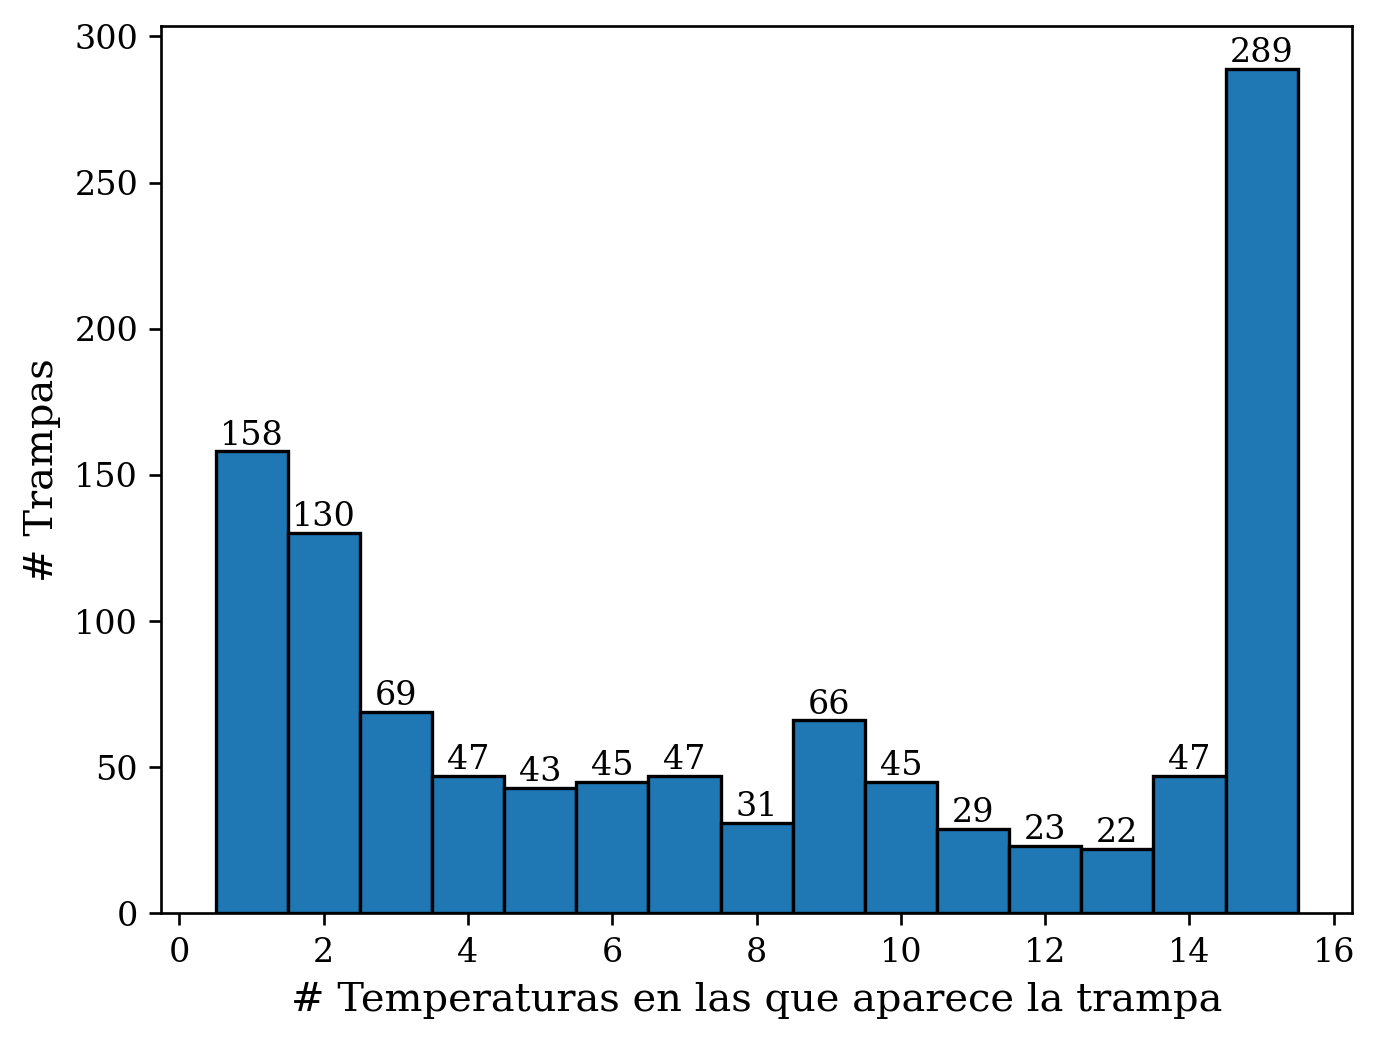

In [11]:
trampas_unicas_por_temp = dict()
for temperatura, carpetas in CARPETAS_POR_TEMP.items():
    trampas_unicas = []
    for dir_idx, _ in enumerate(carpetas):
        for frame_idx in [0, 1]:
            trampas_unicas.extend(trampas_temp[temperatura][2*dir_idx + frame_idx])
    trampas_unicas = set(trampas_unicas)
    trampas_unicas_por_temp[temperatura] = trampas_unicas

lista_todas_trampas = [list(trampas_temp) for trampas_temp in trampas_unicas_por_temp.values()]
lista_todas_trampas = sum(lista_todas_trampas, [])
cuentas = pd.value_counts(lista_todas_trampas).values
counts, edges = np.histogram(cuentas, bins=np.arange(0.5, cuentas.max() + 1.5, 1))
plt.bar(edges[:-1], counts, width=1, align="edge", ec="k")
for count, bin in zip(counts, edges[:-1]):
    plt.text(
        bin + 0.5,
        count,
        f"{count}",
        ha="center", va="bottom",
    )
plt.xlabel("# Temperaturas en las que aparece la trampa")
plt.ylabel("# Trampas")
plt.show()

In [12]:
# Calculo Máscaras por Saturación
mascara_saturacion_temp: dict[int, list[list[list[bool]]]] = dict()
# [temperaturaa][dir_idx][coord_idx][dtph_idx]
for temperatura, carpetas in tqdm(CARPETAS_POR_TEMP.items(), desc="Temperaturas"):
    mascaras_temperatura = []
    for dir_idx, data_dir in enumerate(carpetas):
        
        files_in_dir = [
            file for file in os.listdir(data_dir)
            if (file.endswith(".fits") and ("dTph" in file))
        ]
        files_in_dir.sort(key=lambda x: int(x.rsplit("_")[5][4:]))
        dtph_vals = np.array(dtph_temp[temperatura][2*dir_idx])
        umbrales_dtph: dict[int, list[ArrayLike]] = dict()  # [dtph][frame_idx][row_idx]
        for dtph, file in zip(dtph_vals, files_in_dir):
            test_image = fits.open(f'{data_dir}/{file}')
            row_overscan_len, col_overscan_len = get_rowcol_ovserscan(test_image)
            test_image = correct_overscan(test_image)
            umbrales_dtph[dtph] = []  # para guardar los valores umbrales por fila por dtph
            for frame_idx in [0, 1]:
                test_frame = test_image[frame_idx].data/GANANCIA[frame_idx]
                area_activa = test_frame[
                    1:-row_overscan_len, PRESCAN_PIX+2:-col_overscan_len
                ]
                filtro_inf = area_activa > np.quantile(area_activa, 0.005)
                filtro_sup = area_activa < np.quantile(area_activa, 0.99)
                area_activa_filtrada = np.where(
                    filtro_inf & filtro_sup,
                    area_activa,
                    np.nan
                )
                umbrales_dtph[dtph].append(
                    np.nanmean(area_activa_filtrada, axis=1)
                    - 3*np.nanstd(area_activa_filtrada, axis=1, ddof=1)
                )
        #         plt.plot(
        #             umbrales_dtph[dtph][frame_idx],
        #             np.arange(area_activa_filtrada.shape[0]),
        #             label=f"Frame {frame_idx}",
        #             c=dtph_colors.to_rgba(dtph/CLOCKS_TO_SEC),
        #         )
        # plt.title(f"Umbral de Saturación para {temperatura} K")
        # plt.xlabel("Umbral [e⁻]")
        # plt.ylabel("Fila")
        # plt.show()
        for frame_idx in [0, 1]:
            mascaras_dir = []
            for coord_idx, (coords, intensidades_mask, errores_mask) in enumerate(
                zip(
                    trampas_temp[temperatura][2*dir_idx + frame_idx],
                    intensidades_temp[temperatura][2*dir_idx + frame_idx],
                    errores_temp[temperatura][2*dir_idx + frame_idx],
                )
            ):
                intensidades_mask = np.array(intensidades_mask)
                errores_mask = np.array(errores_mask)
                mascara_trampa = np.zeros_like(intensidades_mask, dtype=bool)
                fila_trampa = coords[1][0]
                for idx, (dtph, intensidad, error) in enumerate(
                    zip(dtph_vals, intensidades_mask, errores_mask)
                ):
                    umbral = umbrales_dtph[dtph][frame_idx][fila_trampa]
                    mascara_trampa[idx] = (intensidad + error) >= umbral
                    # Si la intensidad + error es mayor al umbral, entonces la trampa está saturada
                mascaras_dir.append(mascara_trampa)
            mascaras_temperatura.append(mascaras_dir)
    mascara_saturacion_temp[temperatura] = mascaras_temperatura

Temperaturas:   0%|          | 0/15 [00:00<?, ?it/s]

/tmp/ipykernel_290142/3613292616.py:33: RuntimeWarning: Mean of empty slice
  np.nanmean(area_activa_filtrada, axis=1)
/home/agustin/Documents/FCEN/LAMBDA/LAMBDA_Hub/lambda_env/lib/python3.11/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


In [13]:
total_puntos = 0
puntos_saturan = 0
curvas_saturan = 0
for temp, mascaras in mascara_saturacion_temp.items():
    for dir_idx, mascara_dir in enumerate(mascaras):
        for mascara_coord in mascara_dir:
            # print(mascara_coord)
            total_puntos += mascara_coord.size
            puntos_saturan += np.sum(mascara_coord)
            curvas_saturan += (np.sum(~mascara_coord) < 6)
print(f"Se saturan {puntos_saturan} dipolos de {total_puntos} identificados ({puntos_saturan/total_puntos*100:.2f}%)")
print(f"Se saturan {curvas_saturan} curvas de {len(lista_todas_trampas)} identificadas ({curvas_saturan/len(lista_todas_trampas)*100:.2f}%)")

Se saturan 46 dipolos de 199682 identificados (0.02%)
Se saturan 0 curvas de 8793 identificadas (0.00%)


In [14]:
# Esta celda grafica las curvas para chequear tema saturación. Se puede ignorar

# # Graficamos todas las curvas de intensidad junto a la curva de carga mediana
# for temperatura, carpetas in CARPETAS_POR_TEMP.items():
#     for dir_idx, data_dir in enumerate(carpetas):
#         medianas, standard_devs, tph_vals = dists_por_dir[data_dir]
#         medianas = np.array(medianas)
#         standard_devs = np.array(standard_devs)
#         plt.fill_between(
#             tph_vals,
#             medianas + standard_devs,
#             medianas - standard_devs,
#             color=temp_colors.to_rgba(temperatura), alpha=0.5, zorder=0
#         )
#         for frame_idx in [0, 1]:
#             dtph_vals = np.array(dtph_temp[temperatura][2*dir_idx + frame_idx])
#             for coord_idx, (coords, intensidades_mask, errores_mask, mascara_saturacion) in enumerate(
#                 zip(
#                     trampas_temp[temperatura][2*dir_idx + frame_idx],
#                     intensidades_temp[temperatura][2*dir_idx + frame_idx],
#                     errores_temp[temperatura][2*dir_idx + frame_idx],
#                     mascara_saturacion_temp[temperatura][2*dir_idx + frame_idx],
#                 )
#             ):
#                 intensidades_mask = np.array(intensidades_mask)
#                 errores_mask = np.array(errores_mask)
#                 mascara_saturacion = np.array(mascara_saturacion)
#                 # medianas_filtradas = medianas[mascara_saturacion]
#                 # correlacion = np.dot(
#                 #     intensidades - np.mean(intensidades),
#                 #     medianas_filtradas - np.mean(medianas_filtradas),
#                 # )
#                 # if correlacion > (
#                 #     0.5 * np.linalg.norm(
#                 #         medianas_filtradas - np.mean(medianas_filtradas)
#                 #     )**2
#                 # ):
#                 #     continue
#                 plt.errorbar(
#                     dtph_vals[~mascara_saturacion]/CLOCKS_TO_SEC,
#                     intensidades_mask[~mascara_saturacion],
#                     yerr=errores_mask[~mascara_saturacion],
#                     fmt=".--",
#                     mec="k", mew=0.5, ms=3, capsize=3, elinewidth=0.5,
#                     linewidth=0.5,
#                 )
#         plt.title(f"Temperatura = {temperatura} K")
#         plt.xscale("log")
#         # plt.ylim(0, 2)
#         plt.show()

In [15]:
# Ajustamos los datos (enmascarando por saturación) a las curvas I(t_ph)
systematic_error = 50  # e⁻
# fig, ax = plt.subplots(1, 1, sharex=True, layout="constrained", figsize=(8, 5))
# axs = [ax,]
# # Para los ajustes satisfactorios
# axs[0].set_title("a) Ajustes Satisfactorios al Modelo", loc="left")

plot_idx = 0
skip_plot = True
trampas_ajustadas = []
tau_ajustados = []
err_tau_ajustados = []
pc_ajustados = []
temps_datos_ajustados = []
intensidades_ajustadas = []
error_intensidades_ajustadas = []
tph_ajustados = []
mascaras_ajustadas = []
pvalues_ajustados = []
plot_count = 0
random_plot_gen = np.random.default_rng(2024)
dtph_dense = np.geomspace(DTPH_VALS[0]/1.5, DTPH_VALS[-1]*1.5, 1000)

for temperatura, carpetas in CARPETAS_POR_TEMP.items():
    for dir_idx in range(len(carpetas)):
        for frame_idx in [0, 1]:
            dtph_vals = np.array(dtph_temp[temperatura][2*dir_idx + frame_idx])
            for coord_idx, (
                coords,
                intensidades,
                errores,
                mascara_saturacion,
            ) in enumerate(
                zip(
                    trampas_temp[temperatura][2*dir_idx + frame_idx],
                    intensidades_temp[temperatura][2*dir_idx + frame_idx],
                    errores_temp[temperatura][2*dir_idx + frame_idx],
                    mascara_saturacion_temp[temperatura][2*dir_idx + frame_idx],
                )
            ):
                if np.sum(~mascara_saturacion) < 6:
                    # Si hay menos de 5 puntos para ajustar, no se hace el ajuste
                    continue
                errores = [np.sqrt(e**2 + systematic_error**2) for e in errores]
                dtph_mask = dtph_vals[~mascara_saturacion]
                intensidades_mask = np.array(intensidades)[~mascara_saturacion]
                errores_mask = np.array(errores)[~mascara_saturacion]
                
                idx_pico = np.argmax(intensidades_mask)
                if (dtph_mask[idx_pico] in [dtph_vals[0], dtph_vals[-1]]):
                    continue
                dtph_maxval = dtph_mask[idx_pico]  # s
                intensidad_maxval = np.max(intensidades)  # e⁻
                # Ajustes al Modelo
                tau_estimado = dtph_maxval / 0.296  # CLOCKS
                pc_estimado = intensidad_maxval * 8 / 3_000 / 5.2
                try:
                    popt, pcov = curve_fit(
                        intensidad_func,
                        dtph_mask,
                        intensidades_mask,
                        sigma=errores_mask,
                        absolute_sigma=True,
                        p0=[tau_estimado, pc_estimado],
                        bounds=(
                            [DTPH_VALS[0] / 0.296, 0],
                            [DTPH_VALS[-1] / 0.296, np.inf],
                        ),
                    )
                except RuntimeError:
                    continue
                perr = np.sqrt(np.diag(pcov))
                # Chi² del fit
                grados_libertad = len(dtph_mask) - len(popt)
                chi2_obs = np.sum(
                    (
                        (intensidades_mask - intensidad_func(dtph_mask, *popt))
                        / errores_mask
                    )**2
                )
                p_value = chi2.sf(chi2_obs, grados_libertad)  # Survival function
                # if p_value < 0.05:  # Si el ajuste es satisfactorio
                if True:  # Guardamos todos los resultados
                    trampas_ajustadas.append(coords[-1])
                    tau_ajustados.append(popt[0]/CLOCKS_TO_SEC)  # s
                    err_tau_ajustados.append(perr[0]/CLOCKS_TO_SEC)  # s
                    pc_ajustados.append(popt[1])  # e⁻
                    temps_datos_ajustados.append(temperatura)  # K
                    intensidades_ajustadas.append(intensidades)  # e⁻
                    error_intensidades_ajustadas.append(errores)  # e⁻
                    tph_ajustados.append(dtph_vals/CLOCKS_TO_SEC)  # s
                    pvalues_ajustados.append(p_value)
                    mascaras_ajustadas.append(mascara_saturacion)
                    # # Lo que queda del bloque son solo gráficos
                    # if coords[-1] in trampas_ajustadas:  # Si ya ajusté esta trampa
                    #     # trampa_idx = trampas_ajustadas.index(coords[-1])
                    #     # color = f"C{trampa_idx%10}"
                    #     skip_plot = False
                    # # elif plot_idx > 10:
                    # #     skip_plot = True
                    # else:  # Si es una trampa nueva
                    #     color = f"C{plot_idx%10}"
                    #     plot_idx += 1
                    # if not skip_plot:
                    #     axs[0].plot(
                    #         dtph_dense/CLOCKS_TO_SEC,
                    #         intensidad_func(dtph_dense, *popt),
                    #         c=color, lw=1,
                    #     )
                    #     axs[0].errorbar(
                    #         dtph_mask/CLOCKS_TO_SEC,
                    #         intensidades_mask,
                    #         yerr=errores_mask,
                    #         fmt=f".{color}",
                    #         label=f"{coords[-1]} | {temperatura} K",
                    #         markeredgecolor="k", markeredgewidth=0.5,
                    #         linestyle="",
                    #         ecolor="k", elinewidth=1, capsize=3,
                    #     )
                    # skip_plot = False
# ax.grid()
# ax.set_xscale("log")
# ax.set_xlabel("$t_{ph}\quad\mathrm{[s]}$")
# ax.set_xlim(left=50/CLOCKS_TO_SEC*0.9, right=51200/CLOCKS_TO_SEC*1.1)
# ax.set_ylabel("$I(t_{ph})\quad\mathrm{[e^-]}$")
# ax.set_ylim(bottom=1)
# plt.show()

resultados_ajustes = pd.DataFrame(
    data={
        "Trampa": trampas_ajustadas,
        "Tau": tau_ajustados,
        "Error Tau": err_tau_ajustados,
        "Pc": pc_ajustados,
        "Temperatura": temps_datos_ajustados,
        "Intensidad": intensidades_ajustadas,
        "Error Intensidad": error_intensidades_ajustadas,
        "tph": tph_ajustados,
        "Máscara": mascaras_ajustadas,
        "p-valor": pvalues_ajustados,
    }
)

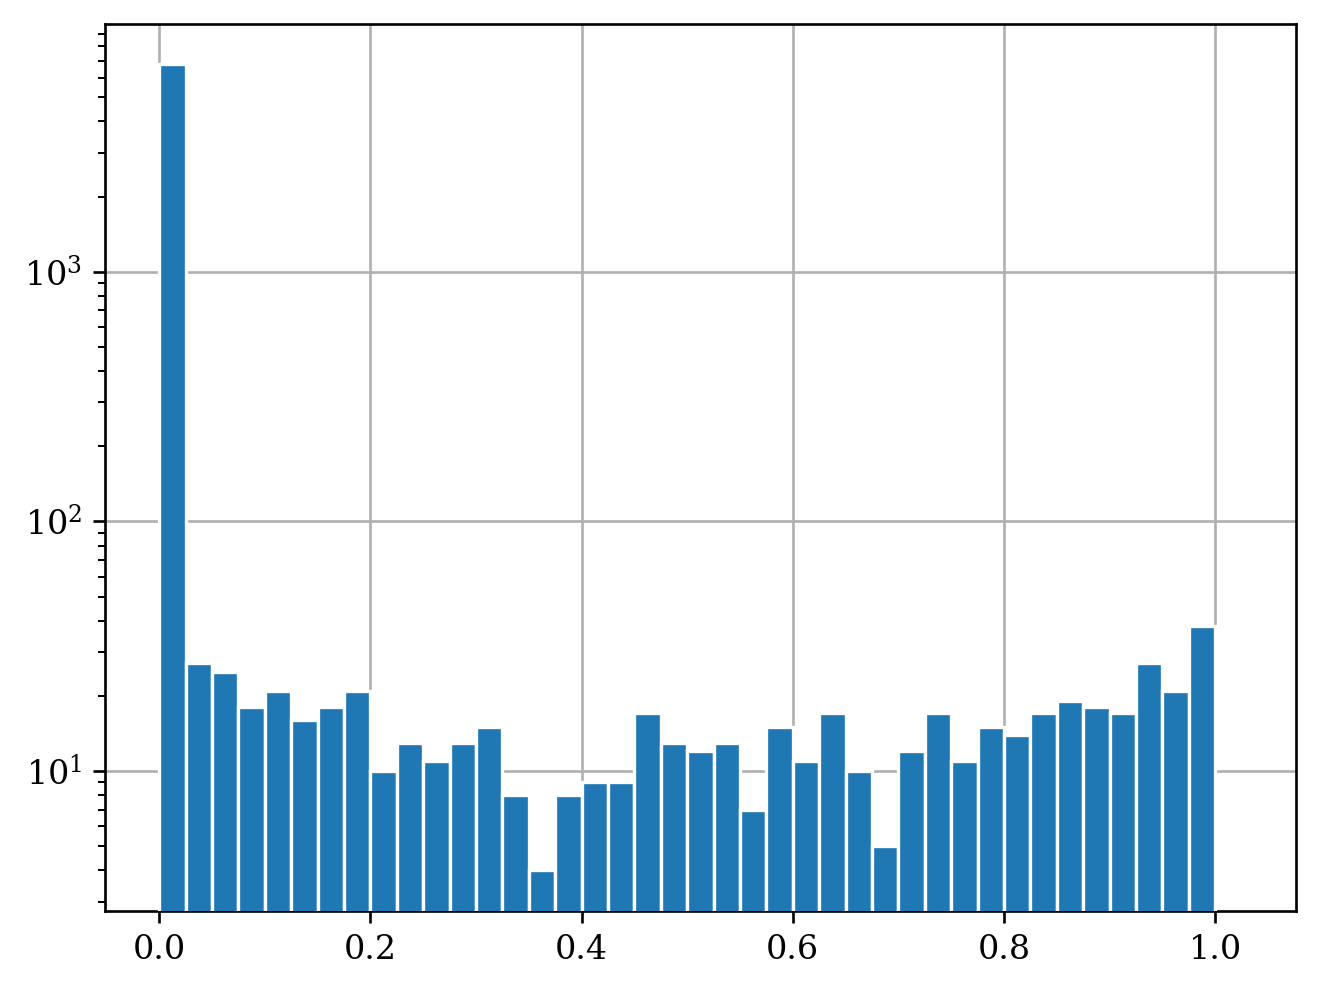

In [16]:
resultados_ajustes["p-valor"].hist(bins=np.arange(0, 1.05, 0.025), edgecolor="w", zorder=10)
plt.yscale("log")
plt.show()

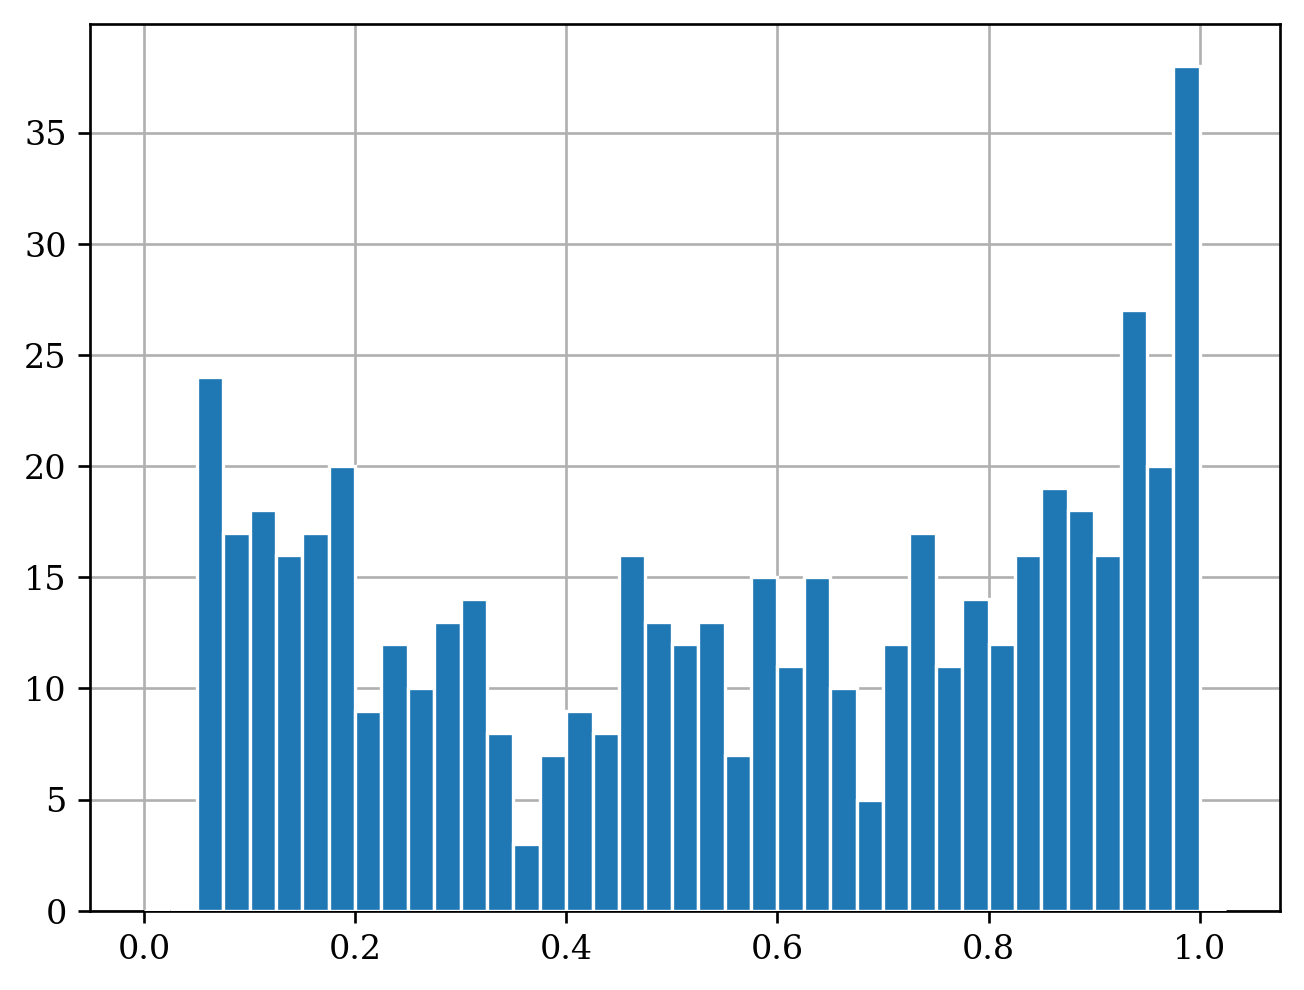

In [110]:
# Otros defectos... No filtrar todos manualmente pero los anoto
# ajustes_malos = [(749, 177), (576, 446), (165, 433), (279, 394), (734, 100), (207, 84), (80, 59), (207, 84), (9, 300), (767, 556), (295, 393)]
doble_respuesta = [(142, 481), (443, 387), (154, 552), (121, 483), (54, 370)]
# ver = [(674, 497)]

filtro_p_valor = resultados_ajustes["p-valor"] > 0.05
filtro_dobles = ~resultados_ajustes["Trampa"].isin(doble_respuesta)
resultados_filtrados = resultados_ajustes[filtro_p_valor & filtro_dobles]

resultados_filtrados["p-valor"].hist(bins=np.arange(0, 1.05, 0.025), edgecolor="w", zorder=10)
# plt.yscale("log")
plt.show()

In [18]:
# # Filtrando por R² y Δτ_e
# delta_tau_rel = resultados_ajustes["Error Tau"] / resultados_ajustes["Tau"]
# intensidades_obs = resultados_ajustes["Intensidad"]
# intensidades_pred = resultados_ajustes.apply(
#     lambda row: intensidad_func(row["tph"], row["Tau"], row["Pc"]), axis=1
# )
# intensidades_avg = intensidades_obs.apply(np.mean)
# ss_residuals = ((intensidades_obs - intensidades_pred)**2).apply(sum)
# ss_total = (
#     (intensidades_obs.apply(lambda x: np.array(x)) - intensidades_avg)**2
# ).apply(sum)
# r_squared = 1 - (ss_residuals / ss_total)

# filtros = (r_squared > 0.7) & (delta_tau_rel < 0.5)
# resultados_filtrados = resultados_ajustes[filtros]

# plt.hist(delta_tau_rel, bins=20, edgecolor="w")
# # plt.axvline(0.5, ls="--", lw=0.5)
# plt.xlabel(r"$\Delta \tau_e / \tau_e$")
# plt.show()

# plt.hist(r_squared, bins=20, edgecolor="w")
# # plt.axvline(0.7, ls="--", lw=0.5)
# plt.xlabel(r"$R^2$")
# plt.show()

In [24]:
# # Filtrando por Intensidad
# resultados_ajustes["I_max"] = resultados_ajustes["Intensidad"].apply(max)
# I_max_threshold = resultados_ajustes.groupby("Trampa")["I_max"].apply(max).quantile(1 - 0.1)
# trampas_filtradas = {
#     trampa for trampa, pasa in (resultados_ajustes.groupby("Trampa")["I_max"].apply(max) > I_max_threshold).items()
#     if pasa
# }
# # Tienen un outlier de alta intensidad que la hace pasar el filtro
# trampas_filtradas.discard((679, 354))
# trampas_filtradas.discard((12, 492))
# trampas_filtradas.discard((172, 428))
# trampas_filtradas.discard((711, 425))

# # Otros comportamientos extraños (revisar?)
# estan_raras = [
#     (30, 479),  # A varios T
#     (596, 151),  # A varios T
#     (585, 478),  # Simplemente no se resuelve el pico a algunas T}
#     (712, 424),
# ]
# for coords in estan_raras:
#     trampas_filtradas.discard(coords)

# # Probablemente saturan y no se puede resolver el pico
# parece_saturan = [
#     (175, 510),  # A varios T
#     (345, 294),  # A varios T
#     (190, 431),  # A varios T
#     (713, 424),
# ]
# for coords in parece_saturan:
#     trampas_filtradas.discard(coords)


# # Filtro los resultados que vamos a usar de acá en adelante
# resultados_filtrados = resultados_ajustes[resultados_ajustes["Trampa"].isin(trampas_filtradas)]
# resultados_filtrados.head()

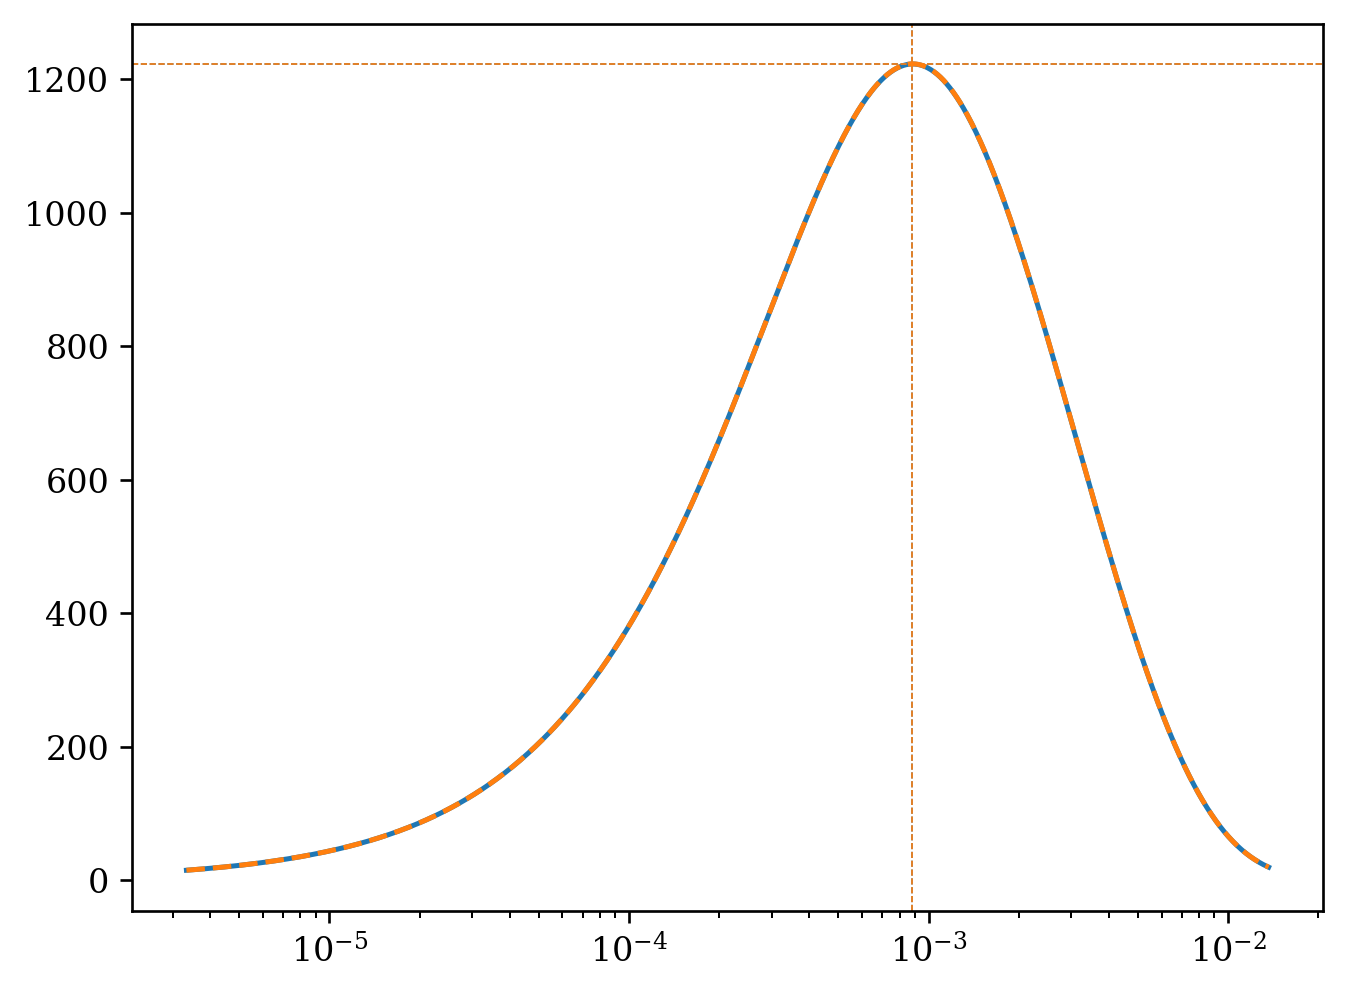

In [34]:
tau_prueba = resultados_filtrados["Tau"].mean()
pc_prueba = resultados_filtrados["Pc"].mean()
tph_prueba = DTPH_VALS/CLOCKS_TO_SEC
tph_dense = np.geomspace(tph_prueba[0], tph_prueba[-1], 1000)
intensidad_prueba = intensidad_func(tph_dense, tau_prueba, pc_prueba)
tau_estimado = tph_dense[np.argmax(intensidad_prueba)] / 0.296
pc_estimado = np.max(intensidad_prueba) * 8 / 3_000 / 5.2
plt.plot(tph_dense, intensidad_prueba, "-")
plt.axvline(tph_dense[np.argmax(intensidad_prueba)], ls="--", lw=0.5)
plt.axhline(np.max(intensidad_prueba), ls="--", lw=0.5)
plt.plot(tph_dense, intensidad_func(tph_dense, tau_estimado, pc_estimado), "--")
plt.axvline(tau_prueba * 0.296, ls="--", lw=0.5, c="C1")
plt.axhline(pc_prueba / 8 * 3_000 * 5.2, ls="--", lw=0.5, c="C1")
plt.xscale("log")
plt.show()

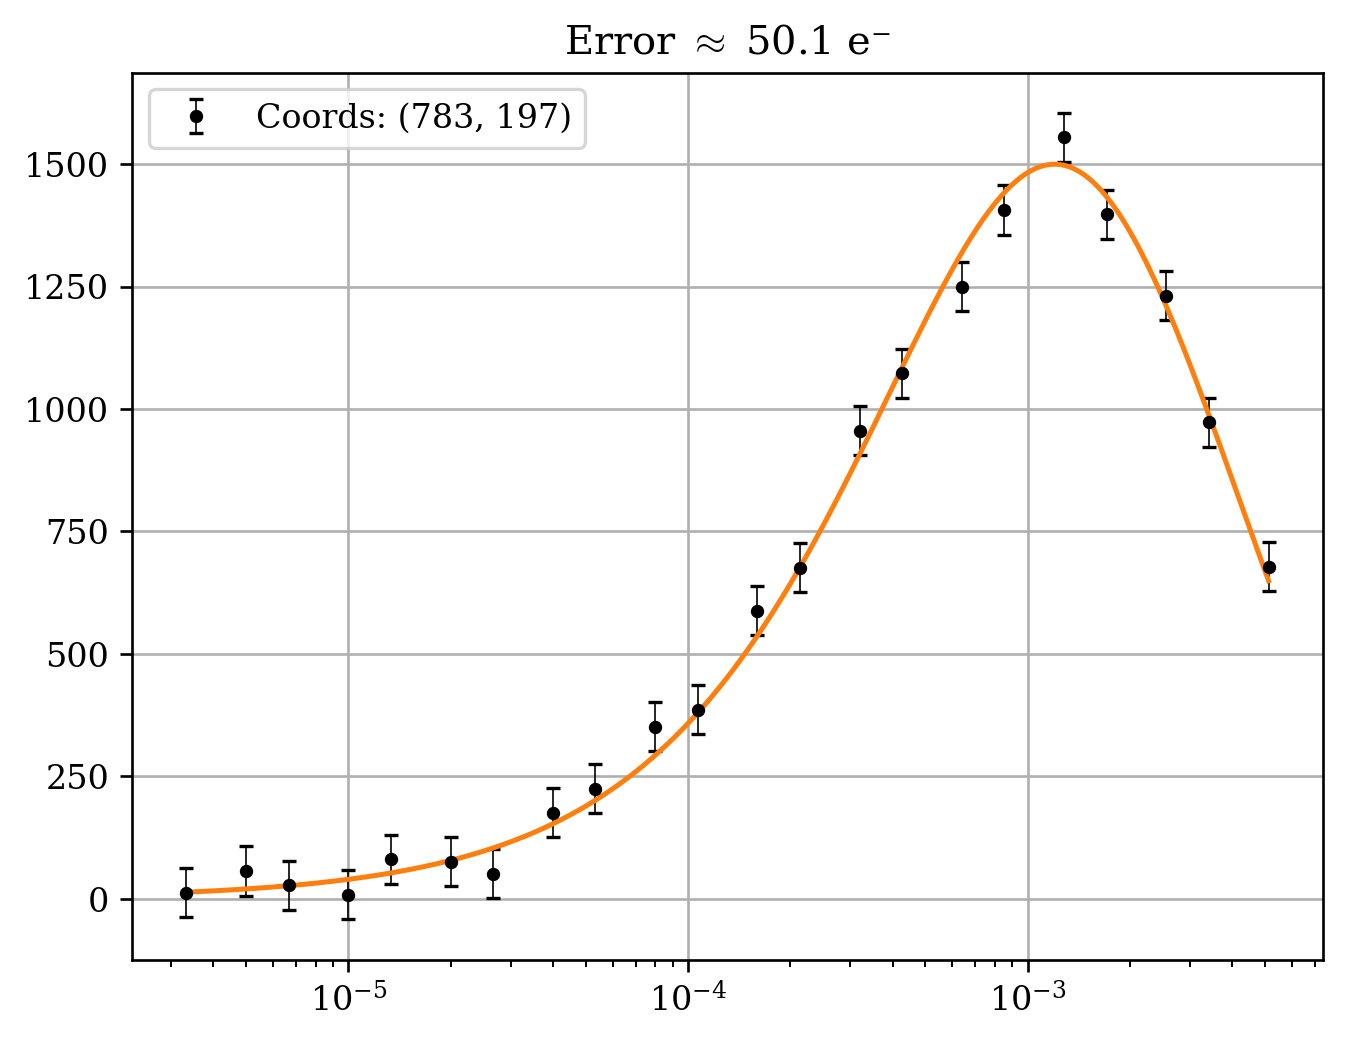

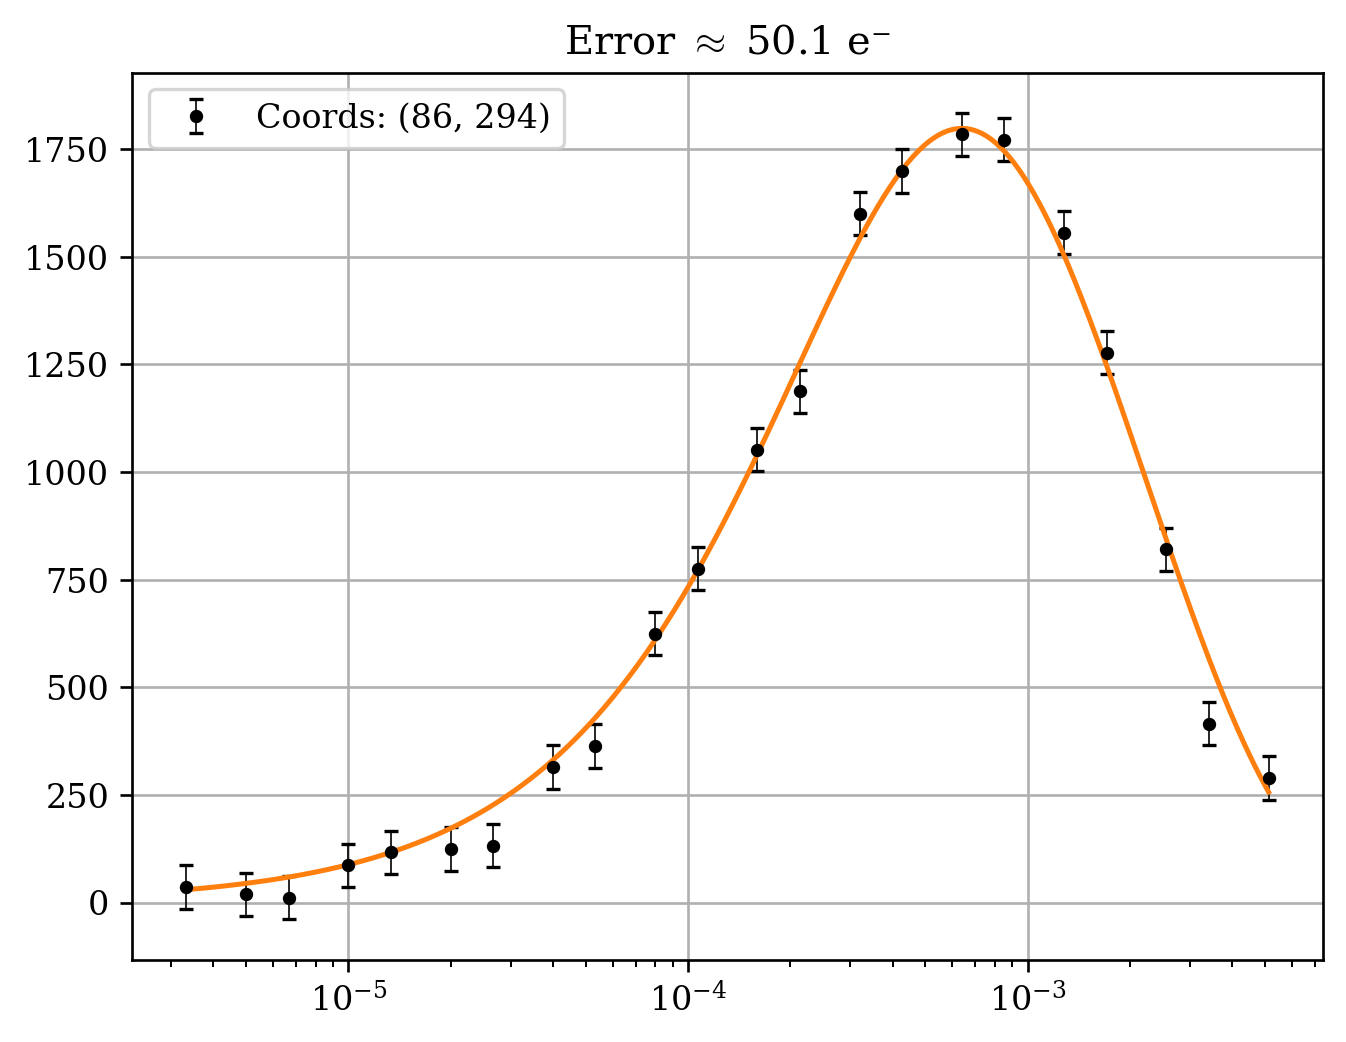

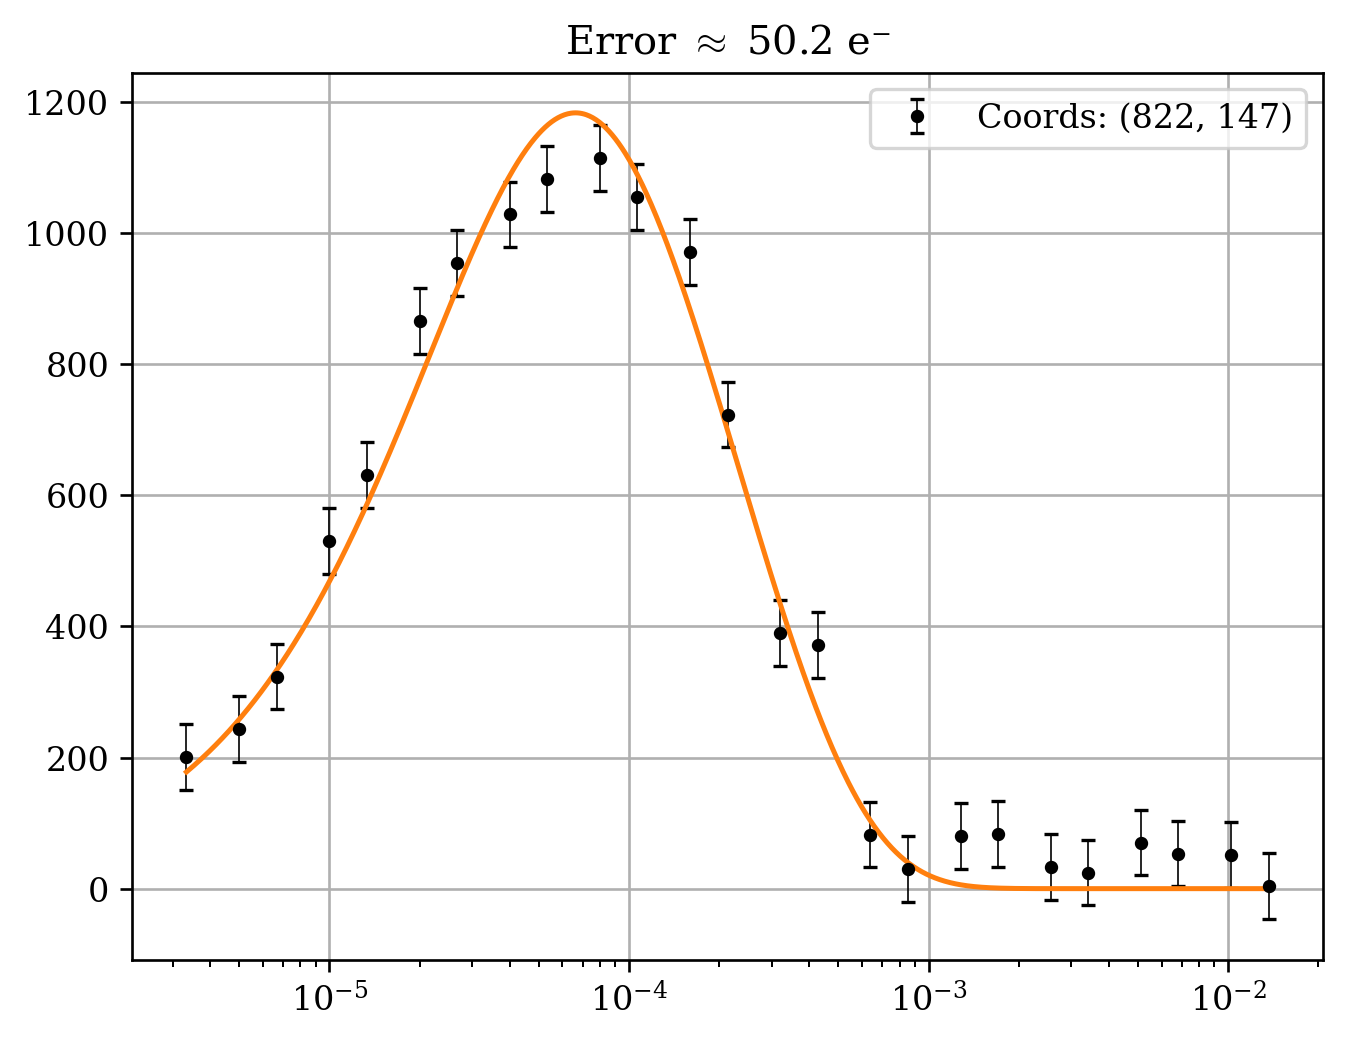

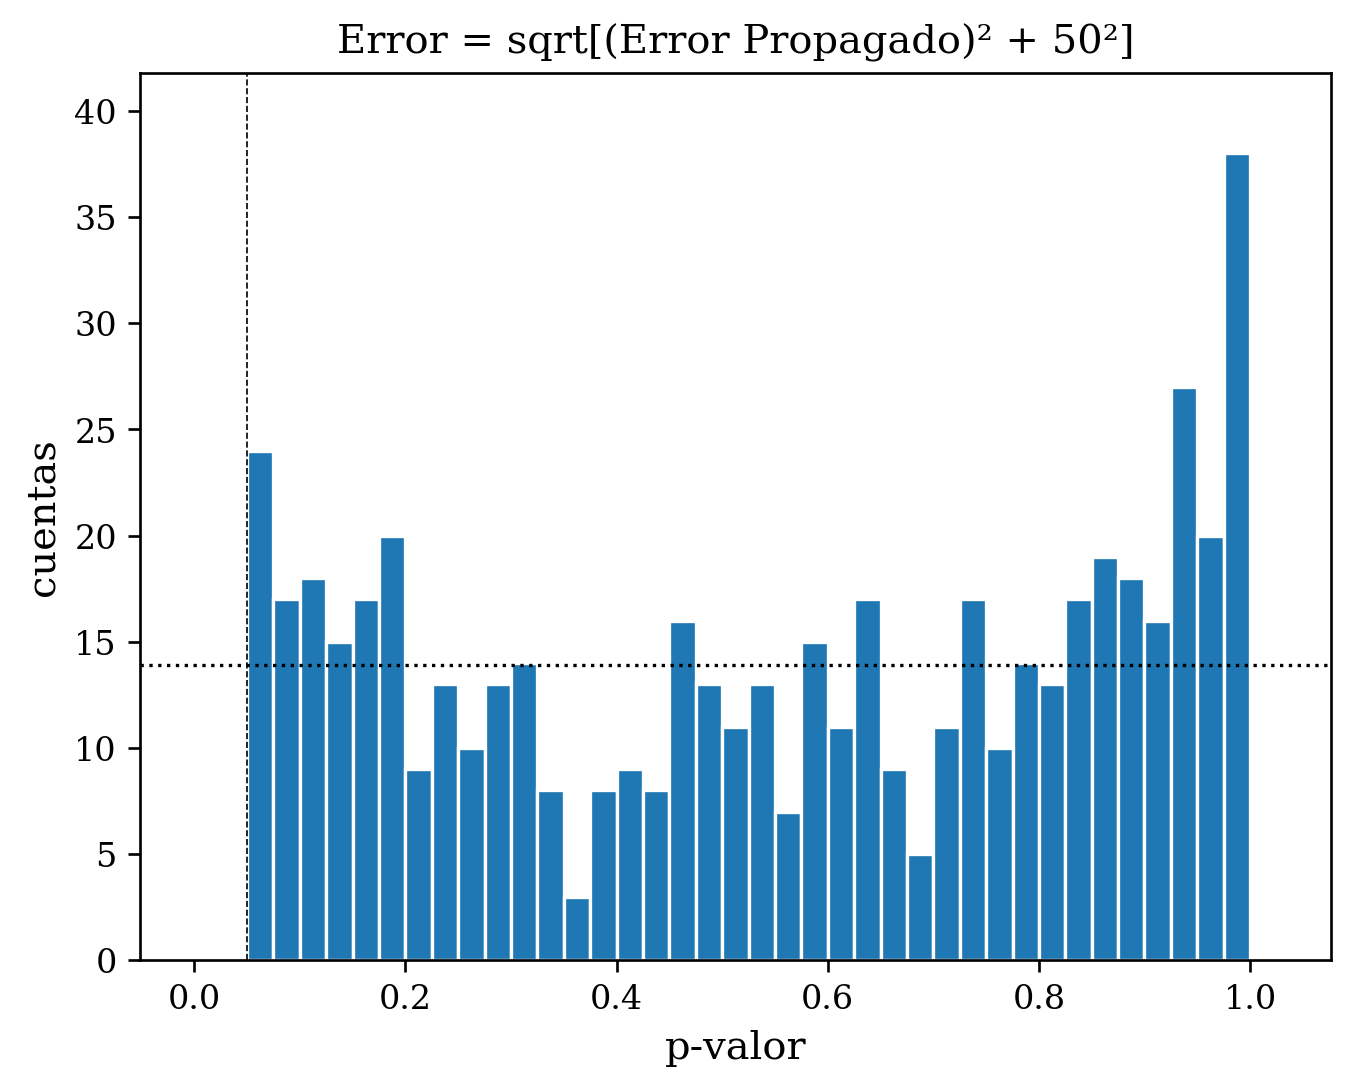

In [25]:
p_vals = []
# error_multiplier = 13.75
for systematic_error in [50,]:
    for row_num, row_data in resultados_filtrados.reset_index().iterrows():
    # for row_num, row_data in resultados_ajustes.reset_index().iterrows():
    # for row_num, row_data in resultados_filtrados.sample(50, random_state=42).reset_index().iterrows():
        if row_data["Trampa"] in [(749, 177), (576, 446), (165, 433), (279, 394), (734, 100), (207, 84), (80, 59), (207, 84), (9, 300), (767, 556), (295, 393), (142, 481), (443, 387), (154, 552), (121, 483)]:
        #     # Excluyendo algunas trampas con comportamientos erraticos para este analisis
            continue
        sat_mask = row_data["Máscara"]
        tph_vals = np.array(row_data["tph"])
        int_vals = np.array(row_data["Intensidad"])
        int_errs = np.sqrt(
            np.array(row_data["Error Intensidad"])**2 - 50**2
            + systematic_error**2
        )
        # Fit again to check
        # tau_estimado = tph_vals[~sat_mask][np.argmax(int_vals[~sat_mask])] / 0.296
        # pc_estimado = np.max(int_vals[~sat_mask]) * 8 / 3_000 / 5.2
        # popt, pcov = curve_fit(
        #     intensidad_func,
        #     tph_vals[~sat_mask],
        #     int_vals[~sat_mask],
        #     sigma=int_errs[~sat_mask],
        #     absolute_sigma=True,
        #     p0=[
        #         tau_estimado,
        #         pc_estimado,
        #     ],
        #     bounds=(
        #         [DTPH_VALS[0] / CLOCKS_TO_SEC / 0.296, 0],
        #         [DTPH_VALS[-1] / CLOCKS_TO_SEC / 0.296, np.inf],
        #     ),
        #     # loss="soft_l1",
        # )
        # Chi² del fit
        grados_libertad = len(tph_vals[~sat_mask]) - 2
        chi2_obs = np.sum(
            (
                (int_vals[~sat_mask] - intensidad_func(tph_vals[~sat_mask], row_data["Tau"], row_data["Pc"]))
                / int_errs[~sat_mask]
            )**2
        )
        p_vals.append(chi2.sf(chi2_obs, grados_libertad))  # Survival function
        # Plots
        if row_num % 250 == 0:
            tph_dense = np.geomspace(tph_vals[0], tph_vals[-1], 1000)
            plt.errorbar(
                tph_vals[~sat_mask], int_vals[~sat_mask], yerr=int_errs[~sat_mask],
                fmt=".", mec="k", mfc="k", ecolor="k", elinewidth=0.5, capsize=2,
                label=f"Coords: {row_data['Trampa']}"
            )
            plt.plot(tph_dense, intensidad_func(tph_dense, row_data["Tau"], row_data["Pc"]), "-")
            plt.plot(tph_vals[sat_mask], int_vals[sat_mask], "xr")
            # plt.plot(tph_dense, intensidad_func(tph_dense, *popt), "--")
            plt.grid()
            plt.legend()
            plt.xscale("log")
            plt.title(rf"Error $\approx$ {int_errs.mean():.3g} e⁻")
            plt.show()

    counts, edges = np.histogram(
        p_vals,
        bins=np.arange(0, 1.05, 0.025)
    )
    avg = np.mean(counts[2:])
    std = np.std(counts[2:], ddof=1)
    plt.bar(edges[:-1], counts, width=np.diff(edges).mean(), align="edge", ec="w")
    plt.axhline(avg, ls=":", c="k", lw=1)
    # for count, bin in zip(counts, bins[:-1]):
    #     plt.text(
    #         bin + 0.025/2,
    #         count,
    #         f"{count}",
    #         ha="center", va="bottom",
    #     )
    plt.axvline(0.05, ls="--", lw=0.5, c="k")
    plt.xlabel("p-valor")
    plt.ylabel("cuentas")
    # plt.yscale("log")
    plt.ylim(top=3*avg)
    plt.title(f"Error = sqrt[(Error Propagado)² + {systematic_error}²]")
    plt.show()
    # plt.hist(p_vals, bins=np.arange(-0.05, 1.1, 0.1), )

In [113]:
# Simplificamos los repetidos tomando el promedio ponderado por el error
trampas_unicas = set(trampas_ajustadas)
for coord in trampas_unicas:
    if trampas_ajustadas.count(coord) == 1:
        continue
    filtro_trampa = (resultados_filtrados["Trampa"] == coord)
    for temperatura in CARPETAS_POR_TEMP.keys():
        filtro_temp = (resultados_filtrados["Temperatura"] == temperatura)
        if sum(filtro_trampa & filtro_temp) > 1:
            plt.errorbar(
                resultados_filtrados.loc[filtro_trampa & filtro_temp, "Temperatura"],
                resultados_filtrados.loc[filtro_trampa & filtro_temp, "Tau"],
                yerr=resultados_filtrados.loc[filtro_trampa & filtro_temp, "Error Tau"],
                fmt=".", label=f"{coord}", mec="k", mew=0.5, capsize=3,
            )
#             # Join this datapoints by averaging them
#             resultados_filtrados.loc[filtro_trampa & filtro_temp, "Tau"] = np.average(
#                 resultados_filtrados.loc[filtro_trampa & filtro_temp, "Tau"],
#                 weights=1/resultados_filtrados.loc[filtro_trampa & filtro_temp, "Error Tau"]**2,
#             )
#             resultados_filtrados.loc[filtro_trampa & filtro_temp, "Error Tau"] = np.sqrt(
#                 1/np.sum(1/resultados_filtrados.loc[filtro_trampa & filtro_temp, "Error Tau"]**2)
#             )
#             # plt.errorbar(
#             #     resultados_filtrados.loc[filtro_trampa & filtro_temp, "Temperatura"],
#             #     resultados_filtrados.loc[filtro_trampa & filtro_temp, "Tau"],
#             #     yerr=resultados_filtrados.loc[filtro_trampa & filtro_temp, "Error Tau"],
#             #     fmt=".", label=f"{coord}", mec="k", mew=0.5, capsize=3,
#             # )
# resultados_filtrados.drop_duplicates(
#     subset=["Trampa", "Temperatura"], keep="first", inplace=True
# )
# resultados_filtrados.reset_index(drop=True, inplace=True)
plt.show()

# Estudio de Homogeneidad de la Distribución Espacial de las Trampas

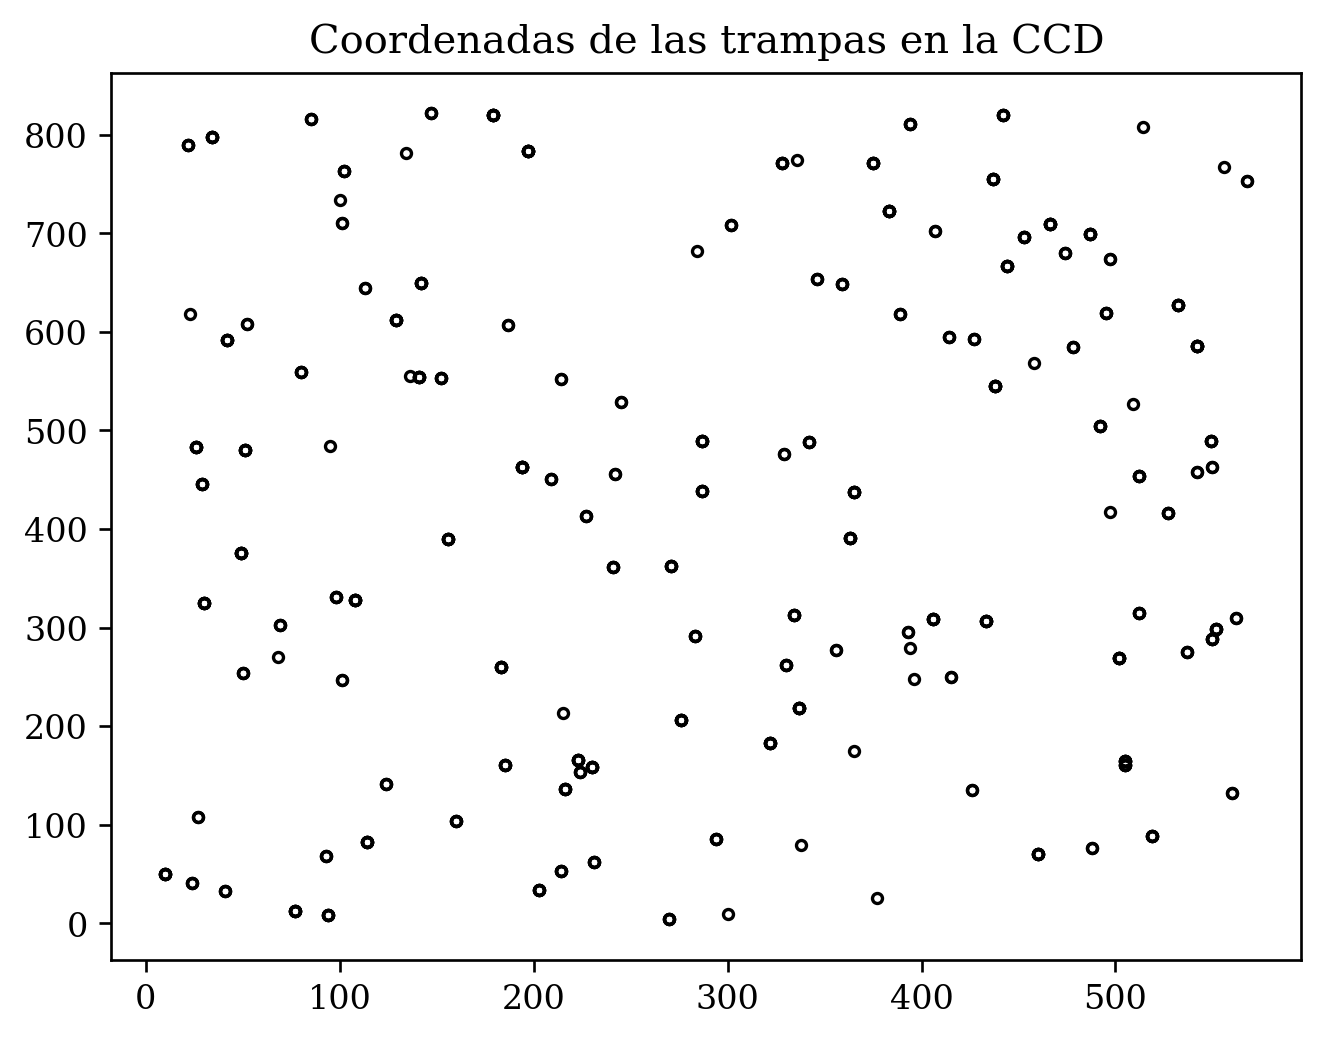

In [114]:
rows = []
cols = []
for coords in resultados_filtrados["Trampa"]:
    rows.append(coords[0])
    cols.append(coords[1])

plt.plot(cols, rows, ".", mec="k", mfc="none")
plt.title("Coordenadas de las trampas en la CCD")
plt.show()

In [115]:
# Distancias Observadas entre Trampas
dists_ccd = []
coords_ccd = np.stack(resultados_filtrados["Trampa"].apply(np.array).to_list())
coords_ccd = np.unique(coords_ccd, axis=0)
for i, coords_i in enumerate(coords_ccd):
    dists_ccd += np.linalg.norm(coords_i - coords_ccd[i+1:], axis=1).tolist()

In [116]:
# Montecarlo
rng = np.random.default_rng(seed=42)
all_coords = [
    [(row, col) for col in range(336 * 2)]
    for row in range(879)
]
all_coords = np.concatenate(all_coords, axis=0)
resultados_montecarlo = []
for _ in tqdm(range(10_000), desc="Simulando Montecarlo"):
    dists_uniform = []
    coords_uniform = all_coords[
        rng.choice(
            np.arange(all_coords.shape[0]),
            size=coords_ccd.shape[0],
            replace=False,
        )
    ]
    # coords_uniform = np.concatenate(
    #     [
    #         np.random.randint(0, 879, (coords_ccd.shape[0], 1)), np.random.randint(0, 336 * 2, (coords_ccd.shape[0], 1))
    #     ],
    #     axis=1,
    # )
    for i, coords_i in enumerate(coords_uniform):
        dists_uniform += np.linalg.norm(coords_i - coords_uniform[i+1:], axis=1).tolist()
    resultados_montecarlo.append(dists_uniform)

Simulando Montecarlo:   0%|          | 0/10000 [00:00<?, ?it/s]

In [ ]:
# dists_ccd = np.sort(dists_ccd)
# ccd_cdf = np.cumsum(np.ones_like(dists_ccd) / dists_ccd.shape[0])
# for dists_uniform in resultados_montecarlo:
#     dists_uniform = np.sort(dists_uniform)
#     uniform_cdf = np.cumsum(np.ones_like(dists_uniform) / dists_uniform.shape[0])
#     plt.plot(dists_uniform, uniform_cdf, "r", alpha=0.1, label="Montecarlo")
# plt.plot(dists_ccd, ccd_cdf, label="Observada")
# plt.xlabel("Distancia entre Trampas [pixeles]")
# plt.ylabel("CDF")
# plt.show()

edges = np.linspace(0, 1_050, 50)
montecarlo_hists = np.zeros((len(resultados_montecarlo), len(edges) - 1))
for i, dists_uniform in enumerate(resultados_montecarlo):
    counts, _ = np.histogram(dists_uniform, bins=edges, density=True)
    montecarlo_hists[i] = counts

# plt.hist(dists_uniform, bins=edges, color="r", edgecolor="w", alpha=0.65, density=True, label="Montecarlo")
# plt.errorbar(
#     x=edges[:-1] + np.diff(edges).mean()/2,
#     y=montecarlo_hists.mean(axis=0),
#     yerr=montecarlo_hists.std(axis=0, ddof=1),  # /np.sqrt(montecarlo_hists.shape[1]),
#     fmt="r.--",
#     lw=1,
#     ecolor="k", capsize=2, markeredgecolor="k",
#     label="Montecarlo",
# )
plt.hist(
    dists_ccd,
    bins=edges,
    edgecolor="w",
    density=True,
    alpha=0.75,
    label="Observed",
    zorder=5,
)
plt.plot(
    edges[:-1] + np.diff(edges).mean()/2,
    montecarlo_hists.mean(axis=0),
    c="r", ls="-", label="Montecarlo", zorder=6,
)
plt.fill_between(
    x=edges[:-1] + np.diff(edges).mean()/2,
    y1=np.quantile(montecarlo_hists, 0.05, axis=0),
    y2=np.quantile(montecarlo_hists, 0.95, axis=0),
    # step="mid",
    color="r", alpha=0.35, zorder=5.5
)
plt.grid()
plt.legend()
plt.xlim(left=0)
plt.xlabel("Distance Between Traps [pixels]")
plt.ylim(bottom=0)
plt.ylabel("PDF")
plt.savefig("plots_paper/spatial_dist.png", dpi=300)
plt.show()

# Estudio Tau

[(4, 270) (8, 94) (12, 77) (33, 41) (34, 203) (41, 24) (50, 10) (53, 214)
 (54, 370) (62, 231) (68, 93) (70, 460) (82, 114) (86, 294) (89, 519)
 (104, 160) (136, 216) (141, 124) (153, 224) (159, 230) (161, 185)
 (161, 505) (165, 505) (166, 223) (183, 322) (206, 276) (218, 337)
 (254, 50) (260, 183) (262, 330) (269, 502) (275, 537) (288, 550)
 (291, 283) (299, 552) (303, 69) (307, 433) (309, 406) (313, 334)
 (315, 512) (325, 30) (328, 108) (331, 98) (361, 241) (362, 271) (376, 49)
 (390, 156) (391, 363) (413, 227) (416, 527) (438, 365) (439, 287)
 (446, 29) (451, 209) (454, 512) (463, 194) (480, 51) (483, 26) (488, 342)
 (489, 287) (489, 549) (504, 492) (545, 438) (553, 152) (554, 141)
 (559, 80) (585, 478) (586, 542) (592, 42) (593, 427) (595, 414)
 (612, 129) (618, 389) (619, 495) (627, 532) (648, 359) (650, 142)
 (654, 346) (667, 444) (680, 474) (696, 453) (699, 487) (708, 302)
 (709, 466) (723, 383) (755, 437) (763, 102) (771, 328) (771, 375)
 (783, 197) (789, 22) (798, 34) (811, 39

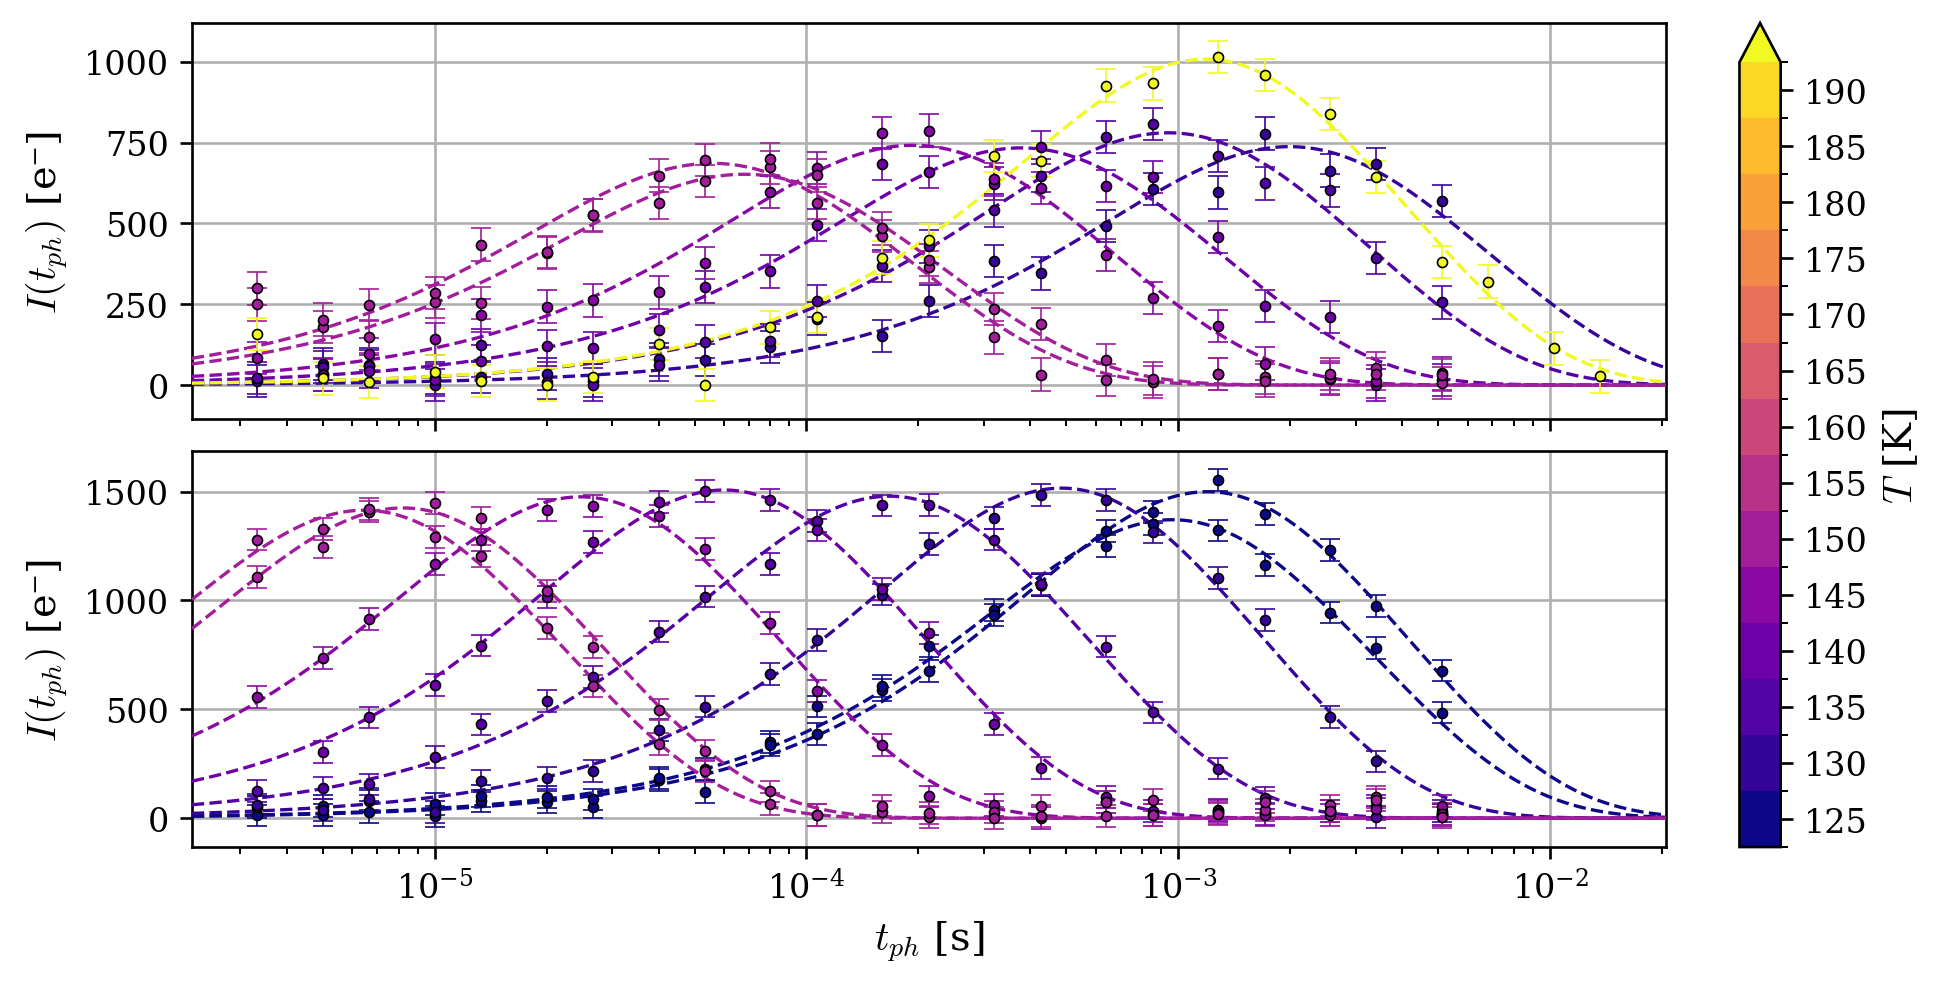

In [109]:
# Graficamos una trampa de ejemplo para varias temperaturas
# trampa_ejemplo = (783, 197)
trampas_unicas, counts = np.unique(
    resultados_filtrados["Trampa"], return_counts=True
)
trampas_varias = trampas_unicas[counts >= 3]
print(trampas_varias)
print(len(trampas_varias))
fig, axs = plt.subplots(2, 1, sharex=True, sharey=False, layout="constrained", figsize=(8, 4))
# axs[0].set_title("a) Curvas 'buenas'", loc="left")
# axs[1].set_title("b) Curvas 'malas'", loc="left")
tph_dense = np.geomspace(DTPH_VALS[0]/1.5, DTPH_VALS[-1]*1.5, 1000)/CLOCKS_TO_SEC
# for trampa_idx, ax in zip([0, 1], axs):
for trampa_ejemplo, ax in zip(
    # [
    #     (443, 387), #(679, 354)
    #     # (618, 389),
    #     # (808, 23) 
    #     (121, 483),
    # ],
    [(54, 370), (783, 197)],
    axs
):
    # trampa_ejemplo = trampas_varias[trampa_idx]
    print(f"Trampa de ejemplo: {trampa_ejemplo}")
    filtro_trampa = (resultados_filtrados["Trampa"] == trampa_ejemplo)

    # text_kwargs_by_temp = {
    #     165: {"va": "bottom", "ha": "center"},
    #     160: {"va": "bottom", "ha": "center"},
    #     150: {"va": "bottom", "ha": "right"},
    #     140: {"va": "center", "ha": "right"},
    #     145: {"va": "bottom", "ha": "right"},
    #     135: {"va": "bottom", "ha": "center"},
    # }
    # text_pad_by_temp = {
    #     165: (0, 100),
    #     160: (0, 50),
    #     150: (0, 50),
    #     140: (-3e-4, 0),
    #     145: (0, 50),
    #     135: (0, 50),
    # }
    for temp, tph_vals, intensidades, errores, mascara_saturacion, tau, pc in zip(
        resultados_filtrados.loc[filtro_trampa, "Temperatura"],
        resultados_filtrados.loc[filtro_trampa, "tph"],
        resultados_filtrados.loc[filtro_trampa, "Intensidad"],
        resultados_filtrados.loc[filtro_trampa, "Error Intensidad"],
        resultados_filtrados.loc[filtro_trampa, "Máscara"],
        resultados_filtrados.loc[filtro_trampa, "Tau"],
        resultados_filtrados.loc[filtro_trampa, "Pc"],
    ):
        tph_vals = np.array(tph_vals)
        intensidades = np.array(intensidades)
        errores = np.array(errores)
        ax.plot(
            tph_vals[mascara_saturacion],
            intensidades[mascara_saturacion],
            "v", c="none",
            mec=temp_colors.to_rgba(temp), mew=0.5, ms=5, zorder=10,
            label="Valores Saturados" if temp == 135 else None
        )
        ax.errorbar(
            tph_vals[~mascara_saturacion],
            intensidades[~mascara_saturacion],
            yerr=errores[~mascara_saturacion],
            fmt=".", c=temp_colors.to_rgba(temp),
            mec="k", mew=0.5, capsize=3, elinewidth=0.5, zorder=20,
            label="Valores Ajustados" if temp == 135 else None
        )
        
        ax.plot(
            tph_dense,
            intensidad_func(tph_dense, tau, pc),
            "--",
            c=temp_colors.to_rgba(temp),
            lw=1, zorder=5,
            label="Ajuste" if temp == 135 else None
        )
        # ax.axhline(
        #     intensidad_func(np.log(8)/(8-1)*tau, tau, pc),
        #     ls="--",
        #     c="r",
        # )
        # ax.text(
        #     tph_vals[max_idx] + text_pad_by_temp[temp][0],
        #     intensidades[max_idx] + text_pad_by_temp[temp][1],
        #     f"{temp} K",
        #     c=temp_colors.to_rgba(temp),
        #     **text_kwargs_by_temp[temp]
        # )
    ax.grid()
    ax.set_xscale("log")
    
    
    # plt.yscale("log")
# axs[0].legend()
for ax in axs:
    ax.set_ylabel("$I(t_{ph})$ [e⁻]")
    ax.set_xlim(tph_dense[0], tph_dense[-1])
axs[1].set_xlabel("$t_{ph}$ [s]")
# axs[1].yaxis.tick_right()
# axs[1].yaxis.set_label_position("right")
fig.colorbar(temp_colors, label="$T$ [K]", extend="max", ax=axs,
             ticks=temp_colors.norm.boundaries+2.5)
plt.show()

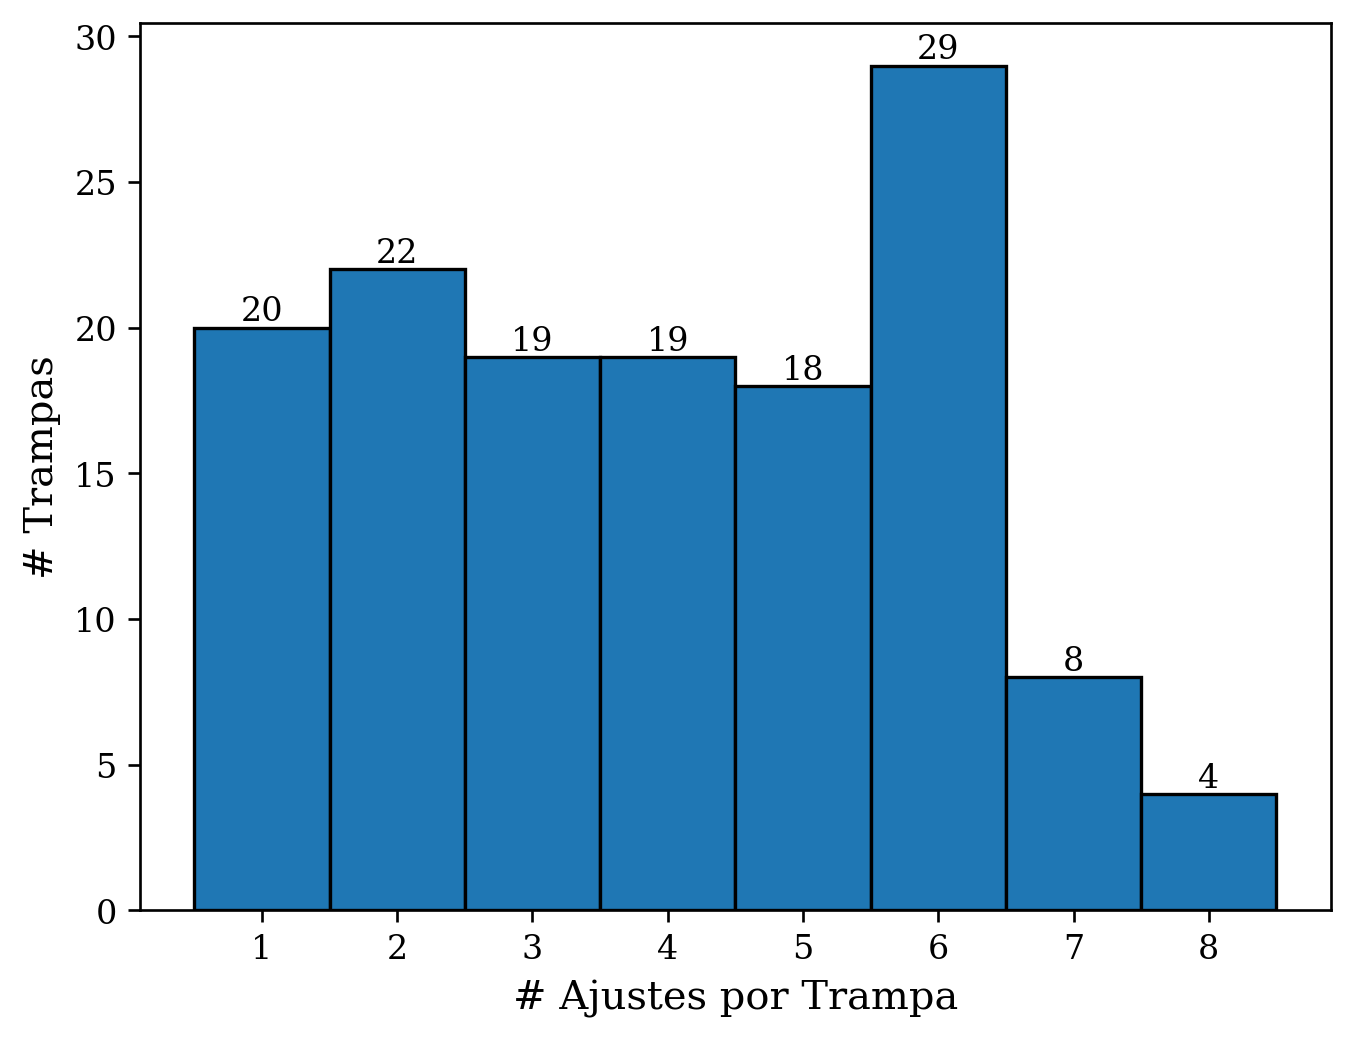

In [40]:
# Histograma de Número de Ajustes Satisfactorios por Trampa
cuentas = resultados_filtrados["Trampa"].value_counts().values
counts, edges = np.histogram(cuentas, bins=np.arange(0.5, cuentas.max() + 1.5, 1))
plt.bar(edges[:-1], counts, width=1, align="edge", ec="k")
for count, bin in zip(counts, edges[:-1]):
    plt.text(
        bin + 0.5,
        count,
        f"{count}",
        ha="center", va="bottom",
    )
plt.xlabel("# Ajustes por Trampa")
plt.ylabel("# Trampas")
plt.show()

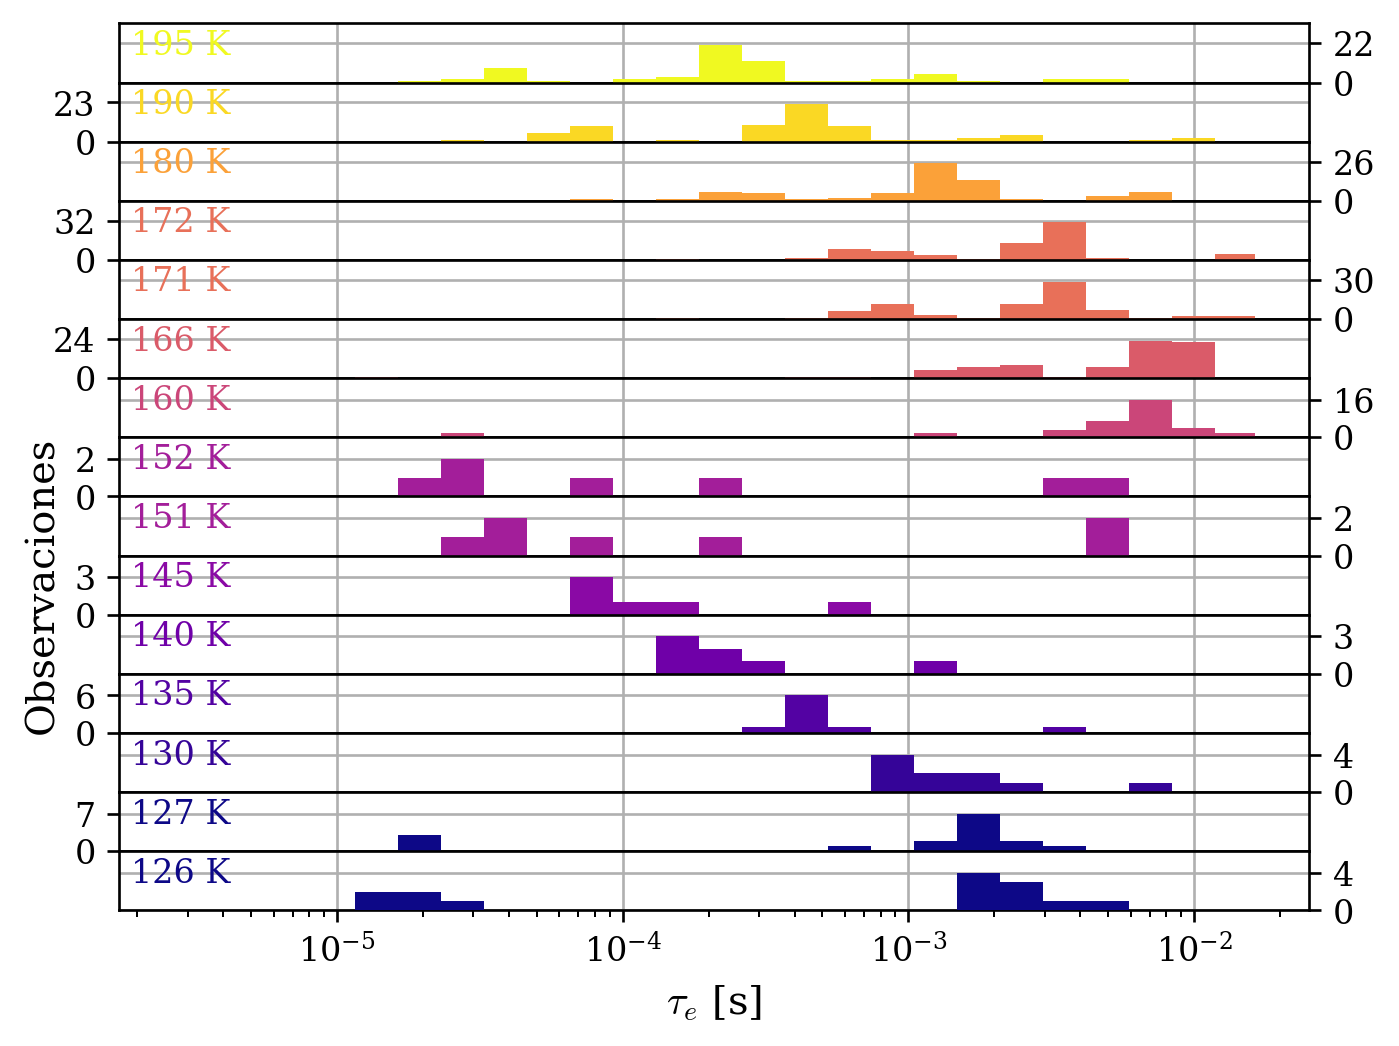

In [41]:
# Gráfico de la distribución de Tau_e a medida que aumenta la temperatura
fig, axs = plt.subplots(len(CARPETAS_POR_TEMP), 1, sharex=True,)
# Sin dejar espacio entre los axs
fig.subplots_adjust(hspace=0)
plot_idx = 0
for temperatura, ax in zip(CARPETAS_POR_TEMP.keys(), axs[::-1]):
    ax.hist(
        resultados_filtrados[resultados_filtrados["Temperatura"] == temperatura]["Tau"],
        bins=DTPH_BINS/CLOCKS_TO_SEC,
        facecolor=temp_colors.to_rgba(temperatura),
        zorder=5,
    )
    # vals, counts = np.unique(
    #     resultados_filtrados[resultados_filtrados["Temperatura"] == temperatura]["Tau"],
    #     return_counts=True,
    # )
    # ax.stem(
    #     vals/CLOCKS_TO_SEC,
    #     counts,
        
    # )
    ax.text(
        0.01, 0.9,
        f"{temperatura} K",
        transform=ax.transAxes,
        ha="left", va="top", c=temp_colors.to_rgba(temperatura),
    )
    ax.grid()
    ylims = ax.get_ylim()
    ax.set_ylim(0, ylims[1]*1.5)
    ax.set_yticks([0, int(ylims[1])])
    if temperatura == 145:
        ax.set_ylabel("Observaciones")
    if not plot_idx % 2:
        # ticks a la derecha
        ax.yaxis.tick_right()
        ax.yaxis.set_label_position("right")
    plot_idx += 1
ax.set_xscale("log")
axs[-1].set_xlabel(r"$\tau_e$ [s]")
# fig.colorbar(temp_colors, label="$T$ [K]", ax=axs,
#              ticks=temp_colors.norm.boundaries+2.5, location="left", )
plt.show()

Recorriendo Trampas:   0%|          | 0/139 [00:00<?, ?it/s]

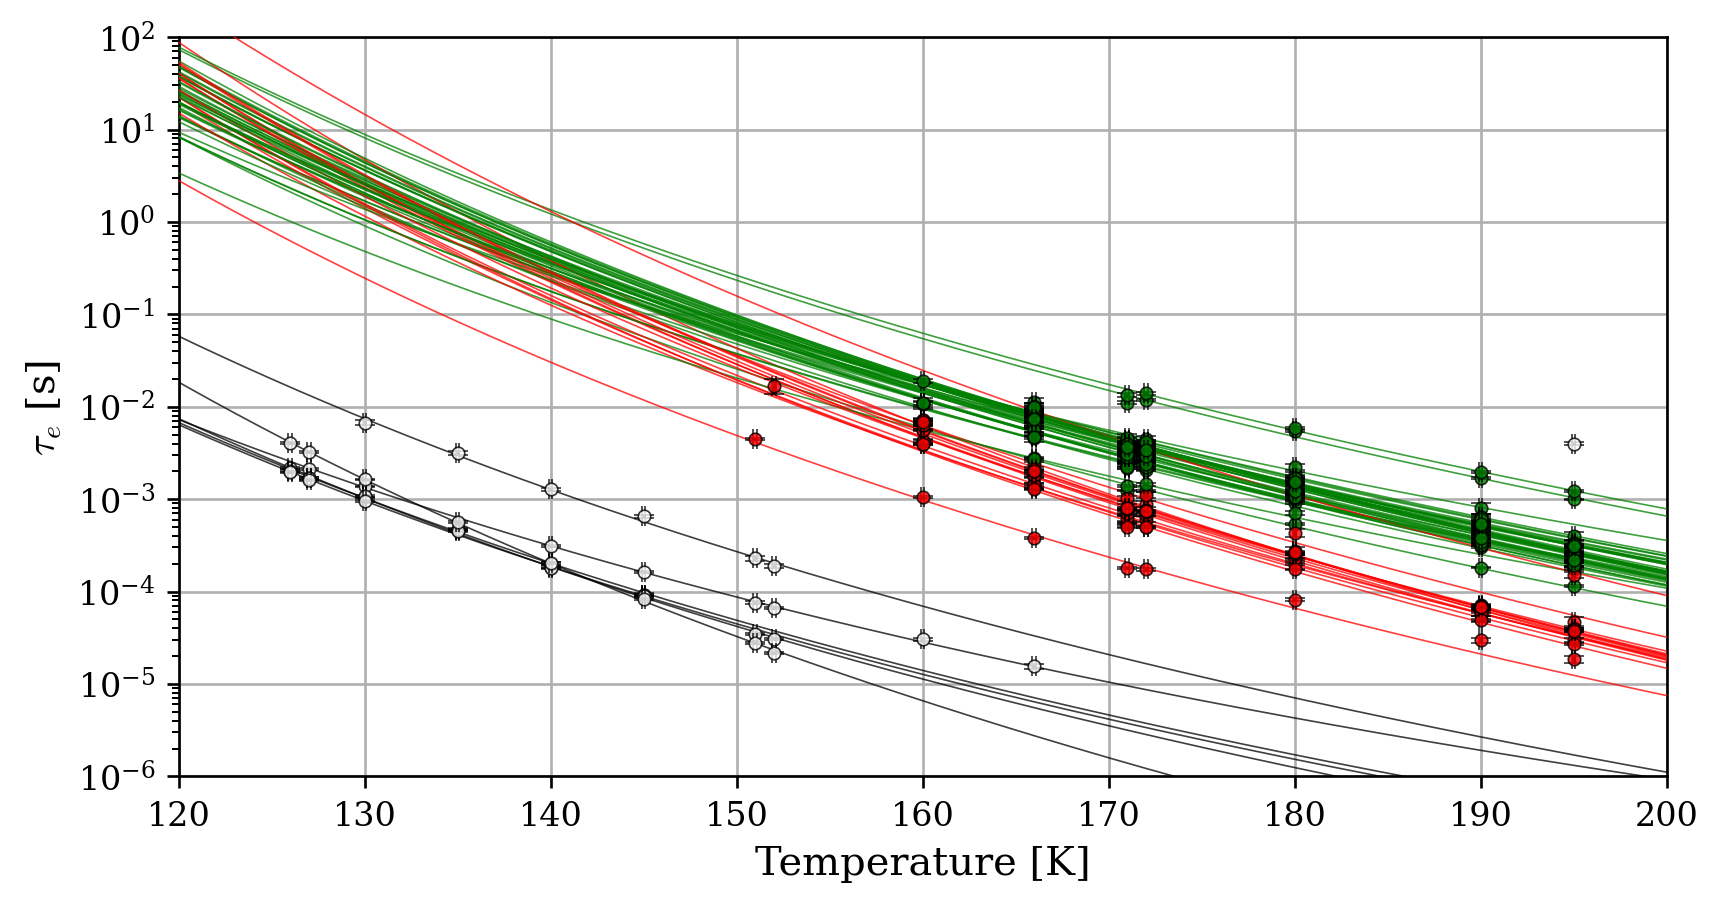

In [107]:
# Buscamos trampas que aparecen en varias temperaturas y graficamos con el ajuste
fig = plt.figure(figsize=(8, 4))
trampas_unicas = set(resultados_filtrados["Trampa"].values)
trampas_en_muchas_temps = []
temps_dense = np.linspace(resultados_filtrados["Temperatura"].min()*0.9, resultados_filtrados["Temperatura"].max()*1.1, 1000)
plot_idx = 0
popt_vals = []
perr_vals = []
grupo = []
# for coord in trampas_unicas:
for coord in tqdm(trampas_unicas, desc="Recorriendo Trampas"):
    if sum(resultados_filtrados["Trampa"] == coord) < 5:
        continue

    trampas_en_muchas_temps.append(coord)
    filtro_trampa = (resultados_filtrados["Trampa"] == coord)
    temps = resultados_filtrados.loc[filtro_trampa, "Temperatura"]
    tau_vals = np.array(resultados_filtrados.loc[filtro_trampa, "Tau"])
    tau_errs = np.array(resultados_filtrados.loc[filtro_trampa, "Error Tau"])
    pc_vals = np.array(resultados_filtrados.loc[filtro_trampa, "Pc"])
    # max_err_relativo = np.array(resultados_filtrados.loc[filtro_trampa, "Maximo Error Relativo"])
    # if (max_err_relativo > 0.3).any():
    #     continue
    # if intensidad_func(np.log(8)/(8-1)*tau_vals[0], tau_vals[0], pc_vals[0]) < 500:
    #     continue
    try:
        popt, pcov = curve_fit(
            tau_func,
            temps,
            tau_vals,
            sigma=tau_errs,
            absolute_sigma=True,
            bounds=([0, 0], [np.inf, np.inf]),
        )
        perr = np.sqrt(np.diag(pcov))
        popt_vals.append(popt)
        perr_vals.append(perr)
    except RuntimeError:
        continue
    # Chi2 del fit
    grados_libertad = len(temps) - len(popt)
    chi2_obs = np.sum(
        (
            (tau_vals - tau_func(temps, *popt))
            / tau_errs
        )**2
    )
    p_value = chi2.sf(chi2_obs, grados_libertad)  # Survival function
    # if p_value < 0.01:
    #     continue
    # plt.title(coord)
    e_val = popt[0] * cte.Boltzmann / cte.eV
    sigma_val = seccion_eficaz(popt[1])
    if (sigma_val < 1e-14) & (e_val > 0.225):
        color = "g"
        grupo.append(0)
    elif (sigma_val > 1e-14) & (e_val > 0.300) & (sigma_val < 1e-12):
        color = "r"
        grupo.append(1)
    else:
        color = "w"
        grupo.append(2)
    plt.errorbar(
        temps,
        tau_vals,
        yerr=tau_errs,
        xerr=0.1,
        fmt=".", c=color, markersize=7.5, mec="k", mew=0.5,
        ecolor="k", elinewidth=1, capsize=3,
        alpha=0.8,
        zorder=100 + plot_idx,
    )
    plt.plot(
        temps_dense,
        tau_func(temps_dense, *popt),
        "-", c=color if color != "w" else "k",
        lw=0.5, alpha=0.75,
        zorder=20 + plot_idx,
    )
    plot_idx += 1

plt.grid()
plt.xlabel("Temperature [K]")
plt.xlim(120, 200)
plt.yscale("log")
plt.ylabel(r"$\tau_e$ [s]")
# plt.ylim(DTPH_VALS[0]/CLOCKS_TO_SEC/2, DTPH_VALS[-1]/CLOCKS_TO_SEC*2)
plt.ylim(1e-6, 1e2)
plt.savefig("plots_paper/ajustes_tau_temp.png", dpi=300)

# plt.ylim(1e-6, 1e-1)
plt.show()

In [102]:
[coords for i, coords in enumerate(trampas_en_muchas_temps) if grupo[i] == 2]

[(820, 179), (586, 542), (50, 10), (54, 370), (70, 460), (783, 197)]

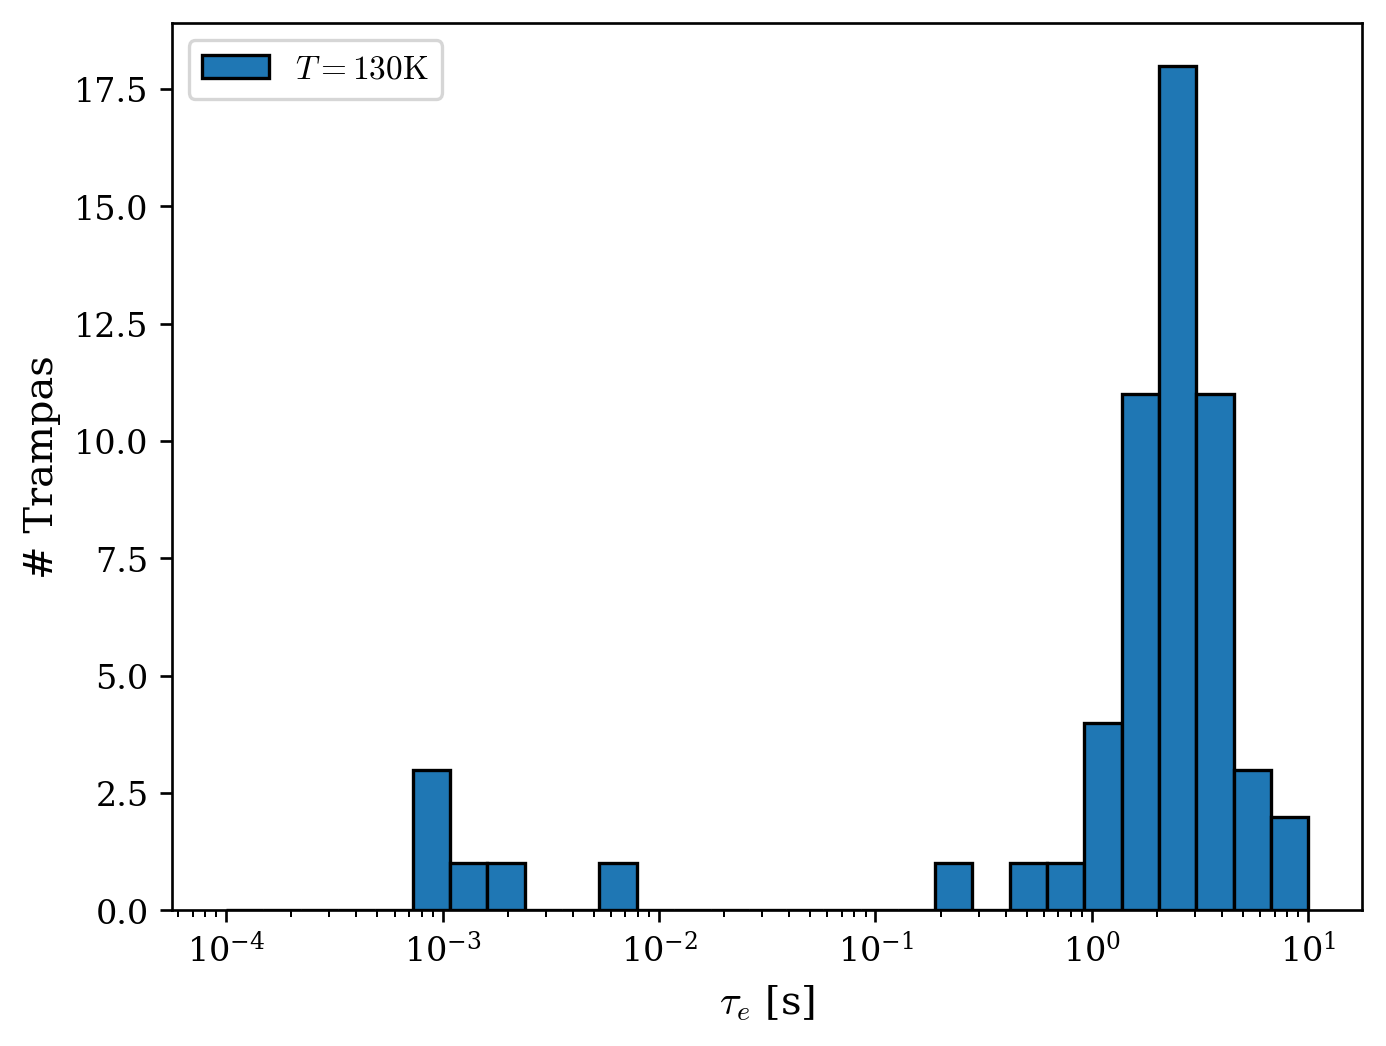

In [43]:
tau_e_130 = np.array([tau_func(130, *popt) for popt in popt_vals])
tau_domain = np.geomspace(1e-4, 1e1, 30)
plt.hist(tau_e_130, bins=tau_domain, ec="k", label=r"$T = 130 \mathrm{K}$")
plt.legend()
plt.xlabel(r"$\tau_e$ [s]")
plt.ylabel("# Trampas")
plt.xscale("log")
plt.show()

In [44]:
popt

array([3.08224683e+03, 1.68788720e-06])

In [45]:
plot_idx

59

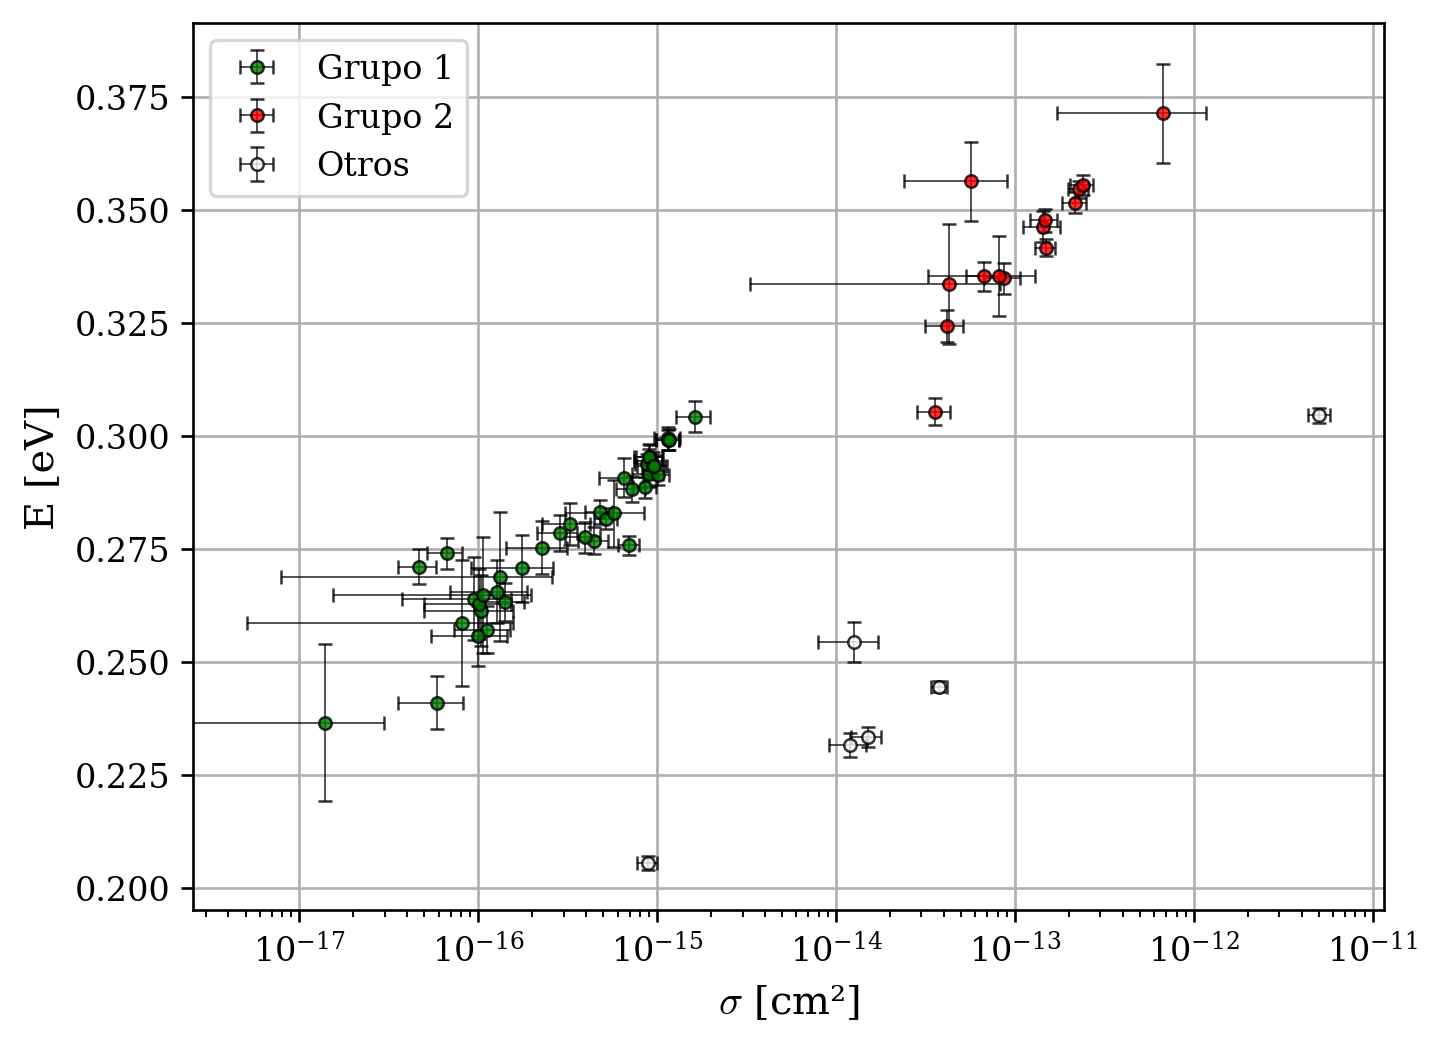

In [91]:
def gaussiana_2d(x, y, amplitud, mu_x, mu_y, sigma_x, sigma_y, rho):
    return amplitud * np.exp(
        -0.5
        * (
            (x - mu_x) ** 2 / sigma_x**2
            + (y - mu_y) ** 2 / sigma_y**2
            - 2 * rho * (x - mu_x) * (y - mu_y) / (sigma_x * sigma_y)
        )
    )


e_vals = np.array([popt[0] * cte.Boltzmann / cte.eV for popt in popt_vals])
e_errs = np.array([perr[0] * cte.Boltzmann / cte.eV for perr in perr_vals])
sigma_vals = np.array([seccion_eficaz(popt[1]) for popt in popt_vals])
sigma_errs = np.array(
    [
        sigma / popt[1] * perr[1]
        for sigma, popt, perr in zip(sigma_vals, popt_vals, perr_vals)
    ]
)
# filtro = (e_vals > 0.15)
# plt.hist(e_vals, bins=20, ec="k")
filtros_clusters = [
    (sigma_vals < 1e-14) & (e_vals > 0.225),
    (sigma_vals > 1e-14) & (e_vals > 0.300) & (sigma_vals < 1e-12),
]
filtros_clusters.append(~filtros_clusters[0] & ~filtros_clusters[1])
for filtro, color, tag in zip(
    filtros_clusters, ["g", "r", "w"], ["Grupo 1", "Grupo 2", "Otros"]
):
    plt.errorbar(
        sigma_vals[filtro],
        e_vals[filtro],
        xerr=sigma_errs[filtro],
        yerr=e_errs[filtro],
        fmt=".",
        markersize=7.5,
        markeredgewidth=0.75,
        markeredgecolor="k",
        ecolor="k",
        capsize=2,
        elinewidth=0.5,
        markerfacecolor=color,
        alpha=0.8,
        label=tag,
        zorder=10,
    )
    # # Agrego una gaussiana asociada a los puntos del grupo
    # if tag != "Otros":
    #     vals = np.array([np.log(sigma_vals[filtro]), e_vals[filtro]]).T
    #     mu = np.mean(vals, axis=0)
    #     std = np.std(vals, axis=0)
    #     corr = np.corrcoef(vals.T)[0, 1]
    #     print(f"mu = {mu}")
    #     print(f"std = {std}")
    #     print(f"corr = {corr}")

    #     x_vals = np.linspace(np.log(1e-17), np.log(1e-11), 100)
    #     y_vals = np.linspace(0.2, 0.4, 100)
    #     X, Y = np.meshgrid(x_vals, y_vals)
    #     Z = gaussiana_2d(X, Y, 1, mu[0], mu[1], std[0], std[1], corr)
    #     cmap = "Greens" if color == "g" else "Reds"
    #     plt.contour(np.exp(X), Y, Z, levels=4, cmap=cmap, zorder=3, alpha=0.75)
plt.grid()
plt.legend()
plt.xlabel("$\sigma$ [cm²]")
plt.xscale("log")
plt.ylabel("E [eV]")
# plt.ylabel("Count")
plt.savefig("plots_paper/sec_ef_energia.png", dpi=300)

plt.show()